<a href="https://colab.research.google.com/github/iliaxant/empirical_mode_decomposition/blob/main/EMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import CubicSpline
from scipy.fft import fft, fftfreq
from scipy.interpolate import PchipInterpolator

5000


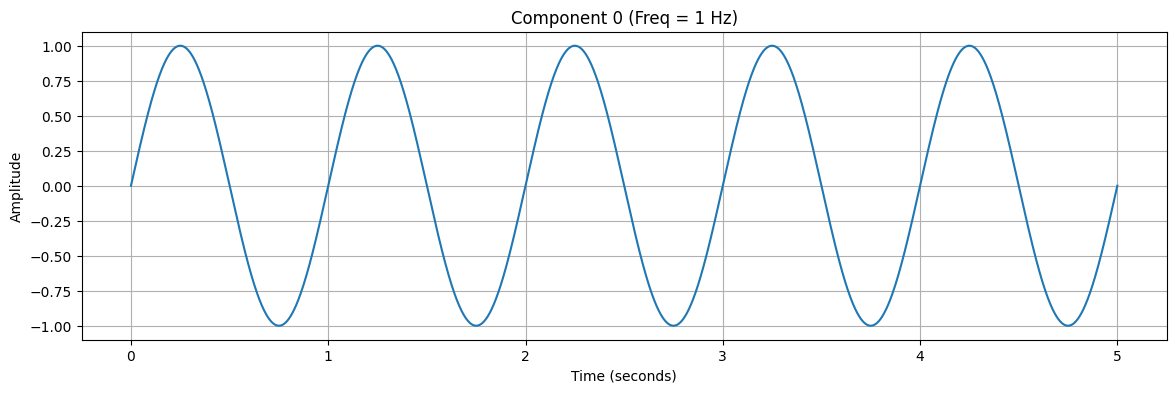

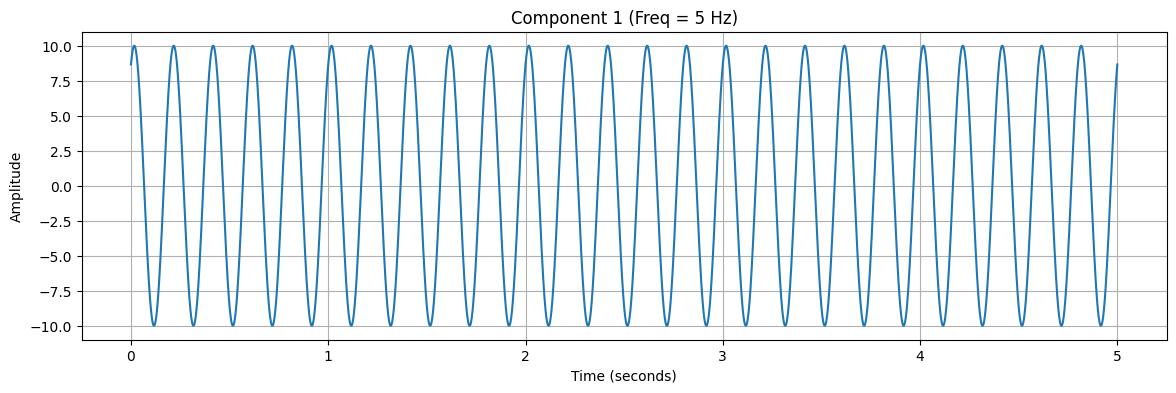

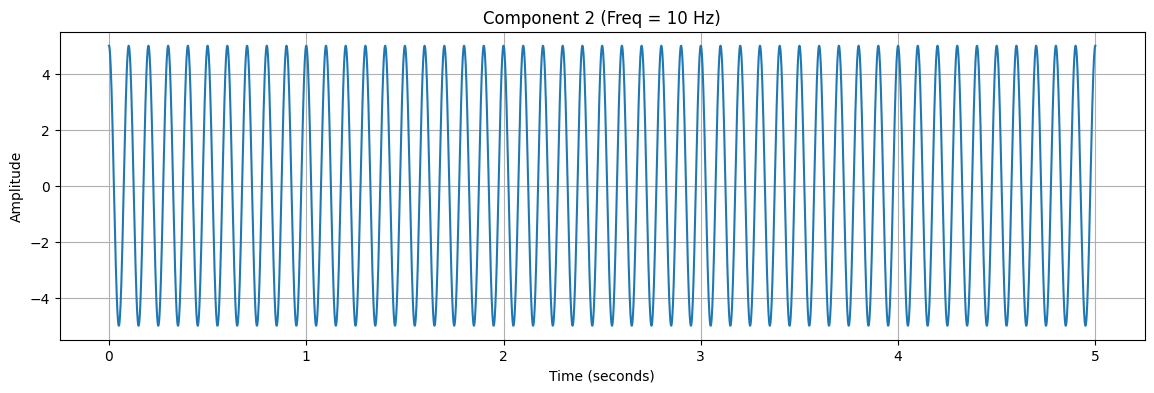

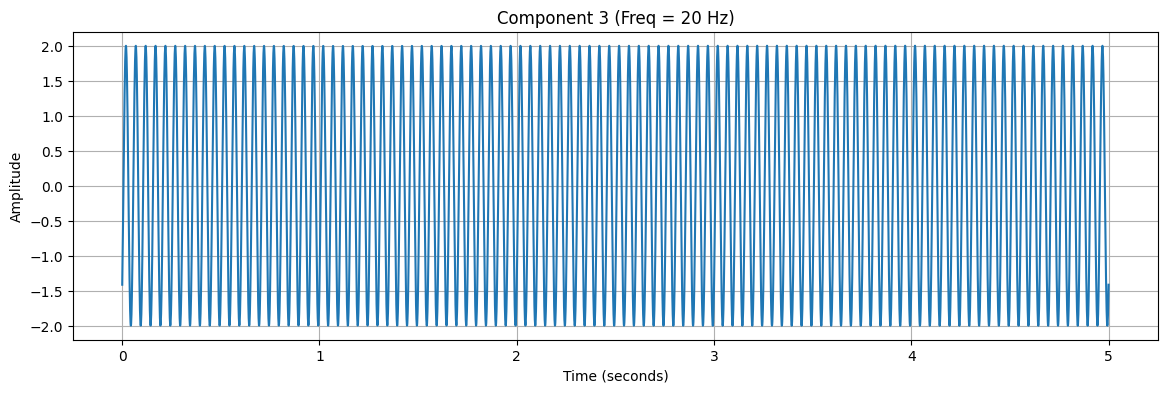

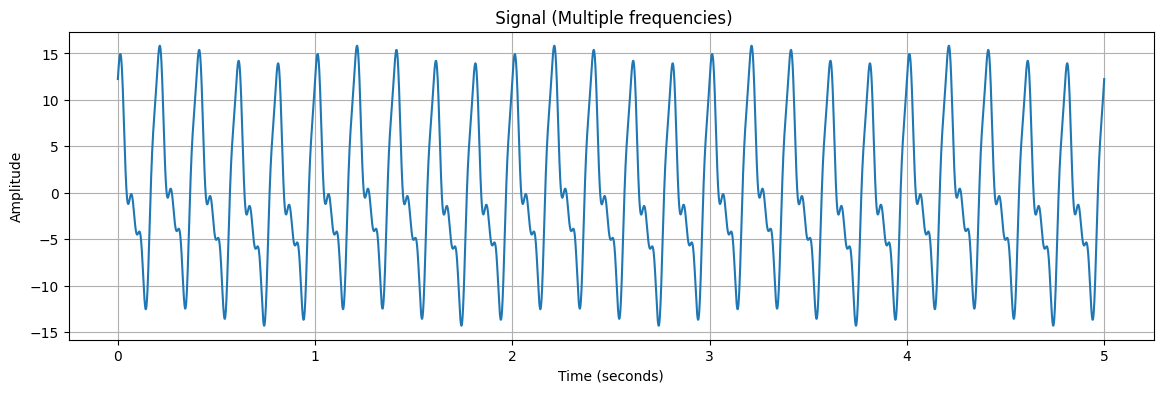

In [7]:
fs = 1000
time_dur = 5

t = np.linspace(0,time_dur, time_dur*fs)
freqs = []
components = []

f1 = 1
c1 = np.sin(2*np.pi*f1*t)
freqs.append(f1)
components.append(c1)

f2 = 5
c2 = 10 * np.sin(2*np.pi*f2*t+ np.pi/3)
freqs.append(f2)
components.append(c2)

f3 = 10
c3 = 5*np.cos(2*np.pi*f3*t)
freqs.append(f3)
components.append(c3)

f4 = 20
c4 = 2*np.sin(2*np.pi*f4*t-np.pi/4)
freqs.append(f4)
components.append(c4)

print(len(c1))
for i in range(len(components)):

    plt.figure(figsize = (14,4))
    plt.plot(t,components[i])
    plt.title(f"Component {i} (Freq = {freqs[i]} Hz)")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

signal = sum(components)

plt.figure(figsize = (14,4))
plt.plot(t,signal)
plt.title(f" Signal (Multiple frequencies)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


In [19]:
def mean_envelope_calc(time, residual, fs, iteration, tol):

    peaks_pos, _ = find_peaks(residual)
    peaks_pos_times = time[peaks_pos]
    peaks_neg, _ = find_peaks(-residual)
    peaks_neg_times = time[peaks_neg]

    if len(peaks_pos) < 2 or len(peaks_neg) < 2:
        return None, False, None, None

    upper_envelope = PchipInterpolator(peaks_pos_times, residual[peaks_pos],
                                       extrapolate=False)(time)
    lower_envelope = PchipInterpolator(peaks_neg_times, residual[peaks_neg],
                                       extrapolate=False)(time)
    mean_env = (upper_envelope + lower_envelope) / 2

    plt.figure(figsize=(16,5))
    plt.title(f'Residual Signal and Mean Envelope (Iteration: {iteration})')

    plt.plot(time,residual, label = 'Residual Signal')

    plt.plot(peaks_pos_times, residual[peaks_pos], 'o', color='r')
    plt.plot(time, upper_envelope, color='r', label = 'Upper Envelope')

    plt.plot(peaks_neg_times, residual[peaks_neg], 'o', color='g')
    plt.plot(time, lower_envelope, color='g', label = 'Lower Envelope')

    plt.plot(time, mean_env, color='black', label = f'Mean Envelope {iteration}')

    plt.grid(True)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

    plt.figure(figsize=(16,5))
    plt.title(f'Mean Envelope (Iteration: {iteration})')
    plt.plot(time, mean_env, color='black')
    plt.grid(True)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.show()

    magn_mean_env = fft(mean_env)
    freq_mean_env = fftfreq(len(mean_env), d=1/fs)

    idxs = np.where(freq_mean_env > 0)
    freq_mean_env = freq_mean_env[idxs]
    magn_mean_env = np.abs(magn_mean_env[idxs])

    plt.figure(figsize=(15, 4))
    plt.plot(freq_mean_env, magn_mean_env, color='teal')
    plt.title(f"FFT of Mean Envelope")
    plt.xlim([0, 25])
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.show()

    extrema_count = len(peaks_pos) + len(peaks_neg)
    zero_crossings = np.sum((residual[:-1] * residual[1:]) < 0)
    imf_condition_1 = abs(extrema_count - zero_crossings) <= 1

    first_idx = min(peaks_pos[0], peaks_neg[0])
    last_idx = max(peaks_pos[-1], peaks_neg[-1])
    mean_env_trimmed = mean_env[first_idx:last_idx+1]
    imf_condition_2 = np.max(np.abs(mean_env_trimmed)) < tol

    print(f"\nExtrema: {extrema_count}, Zero Crossings: {zero_crossings}")
    print(f"Max Mean Envelope Amplitude: {np.max(np.abs(mean_env)):.5f}")
    print(f"IMF Condition 1: {imf_condition_1}, IMF Condition 2: {imf_condition_2}")

    is_imf = imf_condition_1 and imf_condition_2

    return mean_env, is_imf, first_idx, last_idx


def sift(time, residual_signal, fs, imf_num, max_iter, tol):

  residual = residual_signal.copy()

  for iter in range(1,max_iter+1):

    print(f"\n---- Sift iteration: {iter} ----\n")
    mean_envelope, is_imf, first_idx, last_idx = mean_envelope_calc(time, residual, fs, iter, tol)

    if mean_envelope is None:
            print("\nNot enough extrema. Ending sift.")
            print("\n---------------------------")
            return None

    if is_imf:
      print(f"\nIMF conditions met!\nIMF {imf_num} extracted.\n")
      print("\n---------------------------")
      return residual

    new_residual = residual.copy()
    new_residual[first_idx:last_idx + 1] -= mean_envelope[first_idx:last_idx + 1]
    residual = new_residual

    print("\nIMF conditions have not been met...")
    print("\n---------------------------")


  print(f"\nReached max iterations. Returning best effort IMF {imf_num}.\n")
  print("\n---------------------------")

  return residual


def emd(time, signal, fs, max_imfs=10, max_sift_iter=10, emd_tol = 1e-2, sift_tol=1e-3):

    residual = signal.copy()
    imfs = []
    print("\nEMD initiated!")

    for imf_num in range(1, max_imfs+1):

      print(f"\n=============== Extraction of IMF {imf_num} ===============")
      imf = sift(time, residual, fs, imf_num, max_sift_iter, sift_tol)
      print(f"\n===========================================================")

      if imf is None:
        print("Stopping EMD: Residual signal not decomposable.")
        break

      imfs.append(imf)
      residual = residual - imf

      if np.linalg.norm(residual) < emd_tol:
        print("Stopping EMD: Residual signal energy is low.")
        break

    return imfs, residual


EMD initiated!

=============== Extraction of IMF 1 ===============

---- Sift iteration: 1 ----



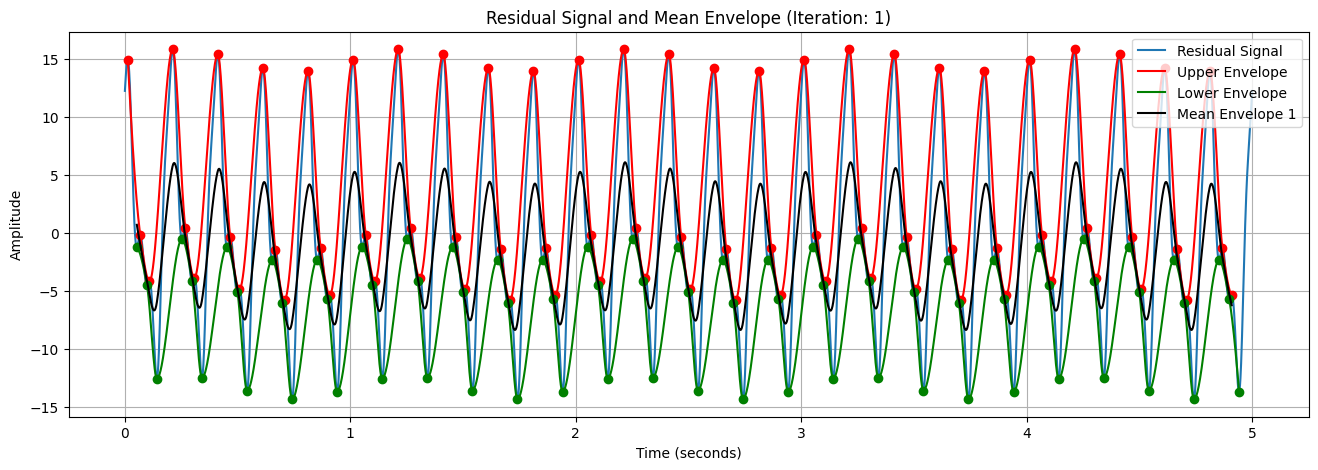

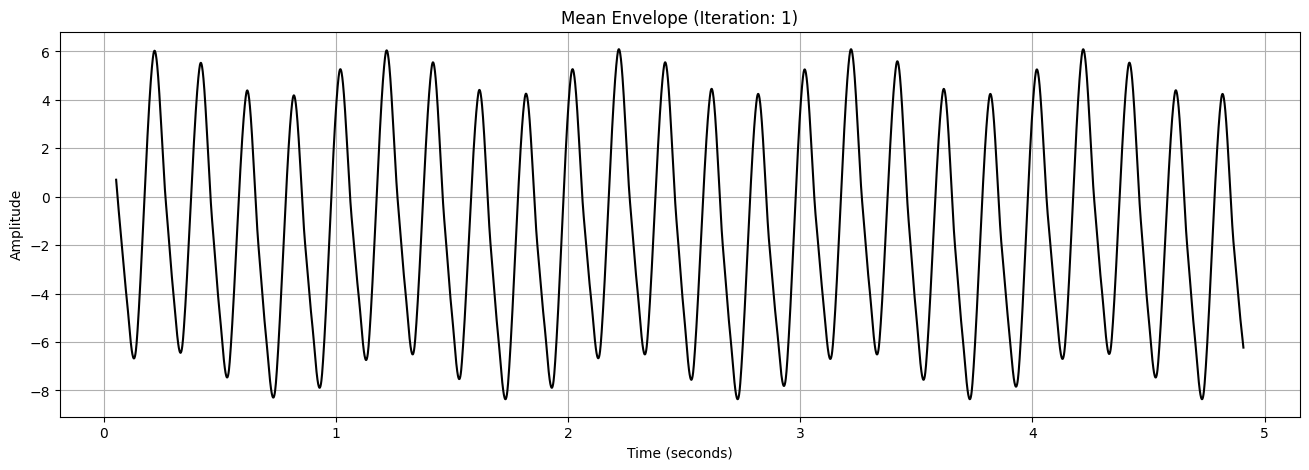

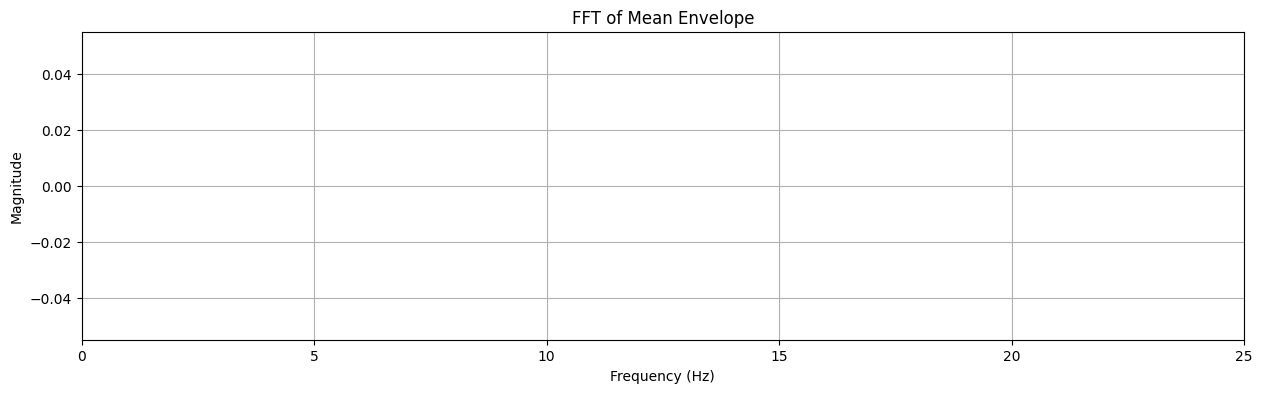


Extrema: 150, Zero Crossings: 60
Max Mean Envelope Amplitude: nan
IMF Condition 1: False, IMF Condition 2: False

IMF conditions have not been met...

---------------------------

---- Sift iteration: 2 ----



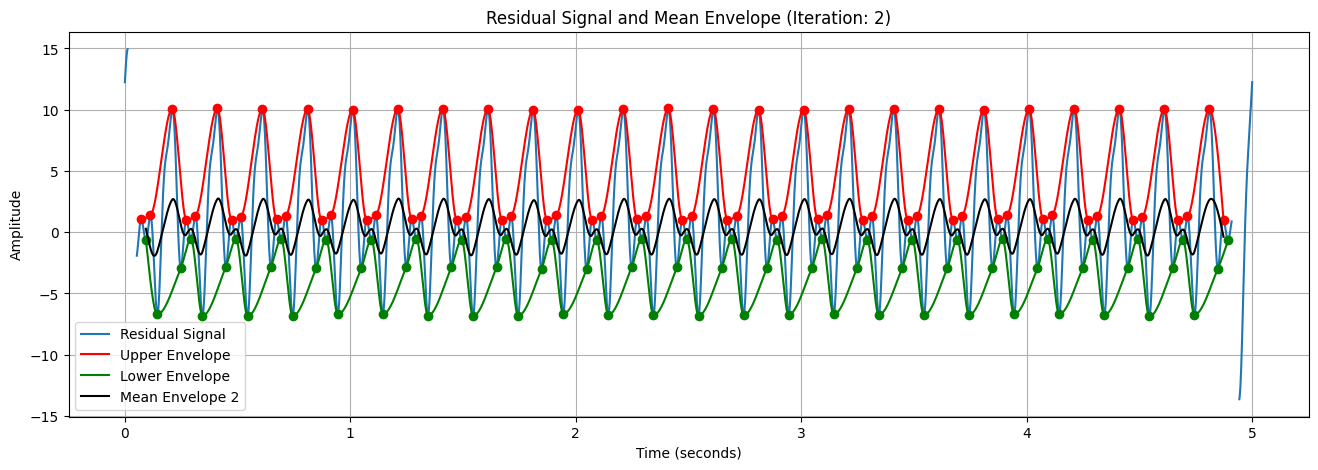

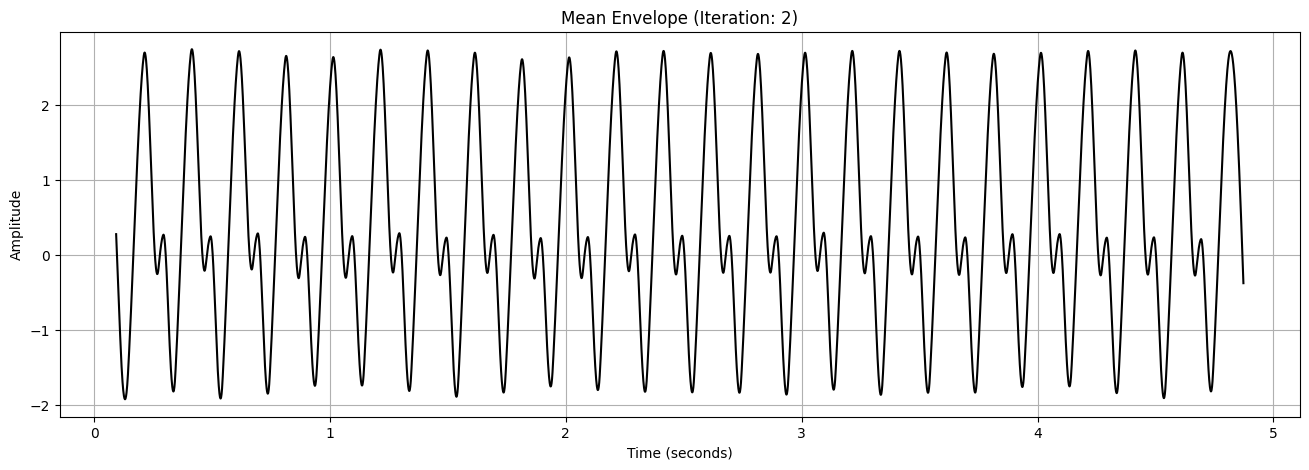

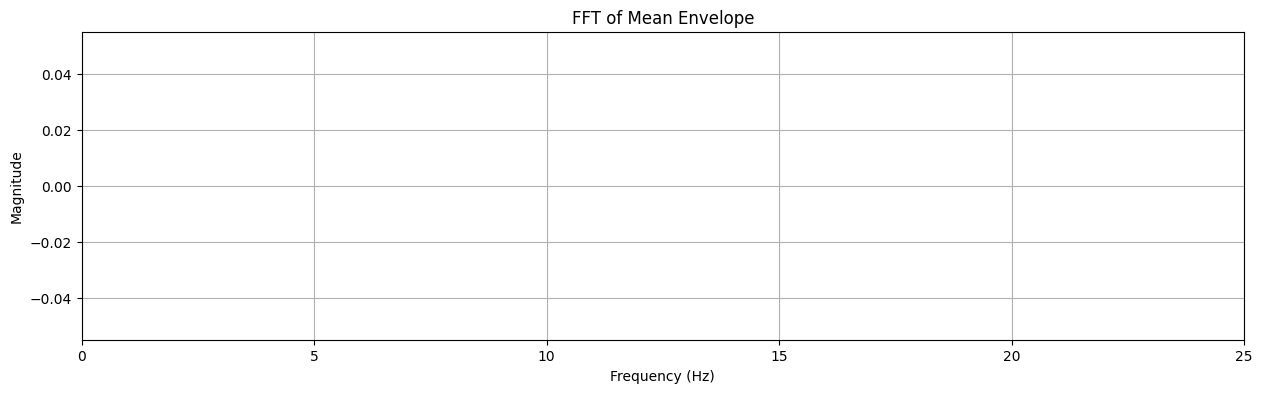


Extrema: 146, Zero Crossings: 148
Max Mean Envelope Amplitude: nan
IMF Condition 1: False, IMF Condition 2: False

IMF conditions have not been met...

---------------------------

---- Sift iteration: 3 ----



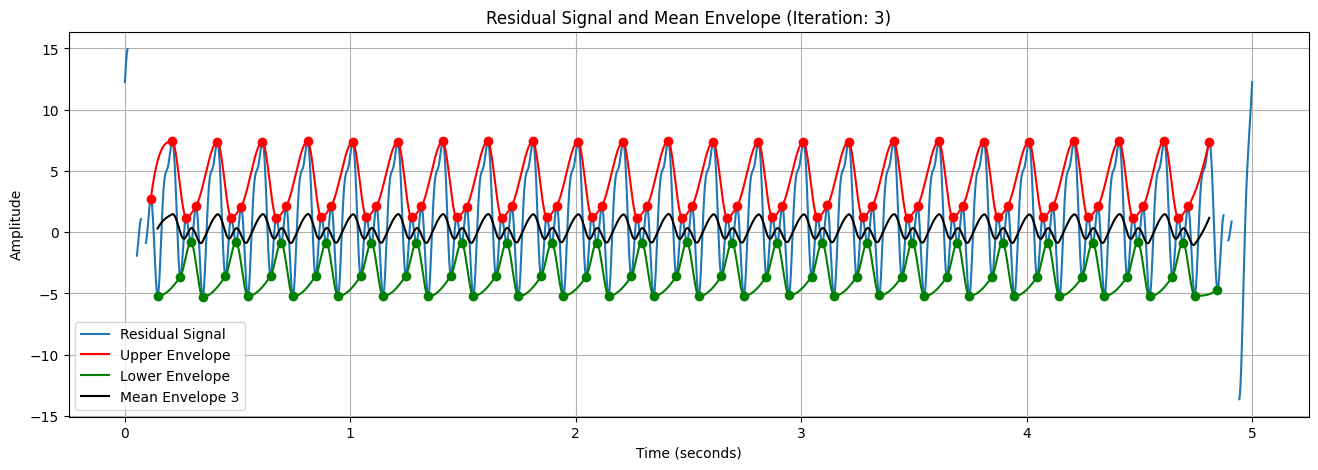

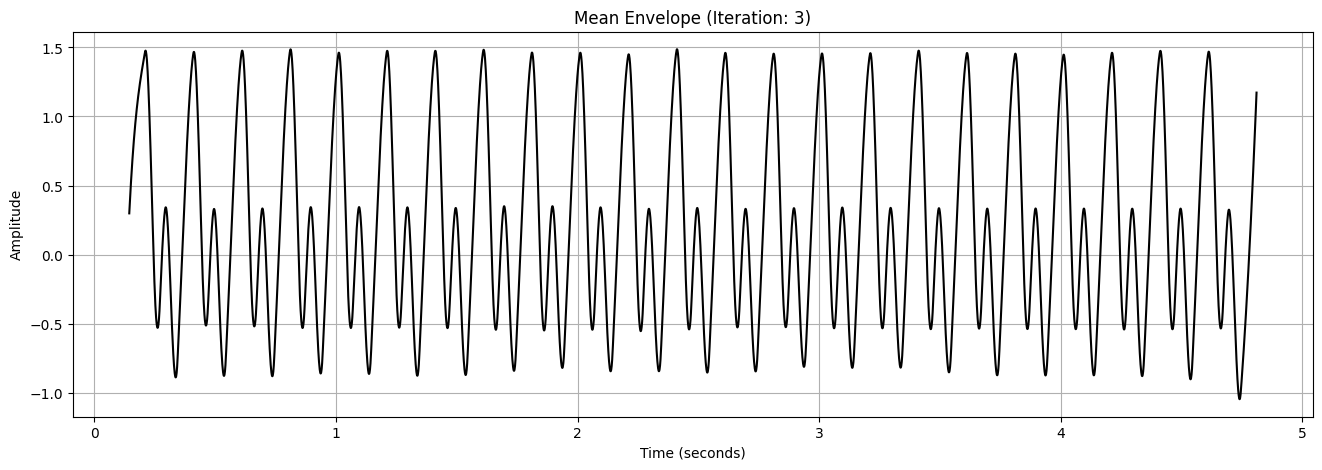

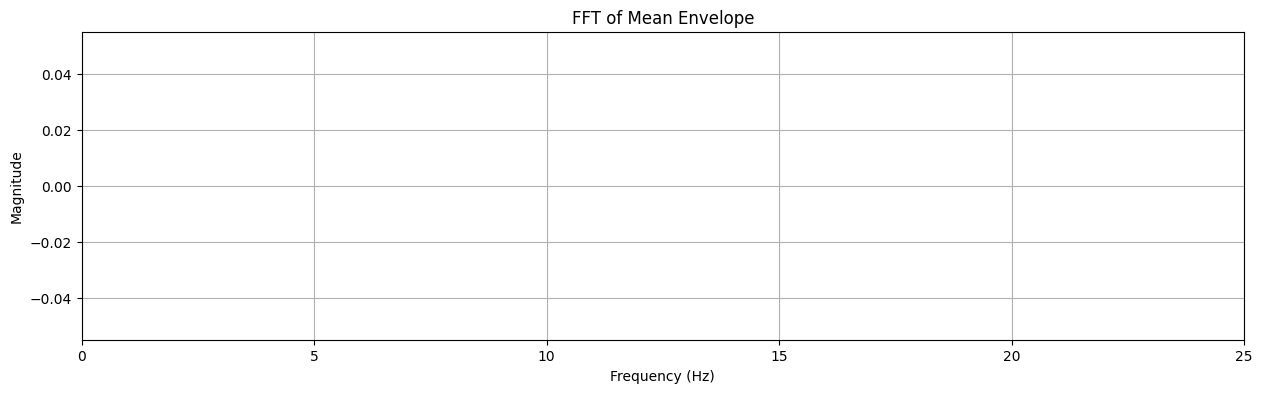


Extrema: 142, Zero Crossings: 146
Max Mean Envelope Amplitude: nan
IMF Condition 1: False, IMF Condition 2: False

IMF conditions have not been met...

---------------------------

---- Sift iteration: 4 ----



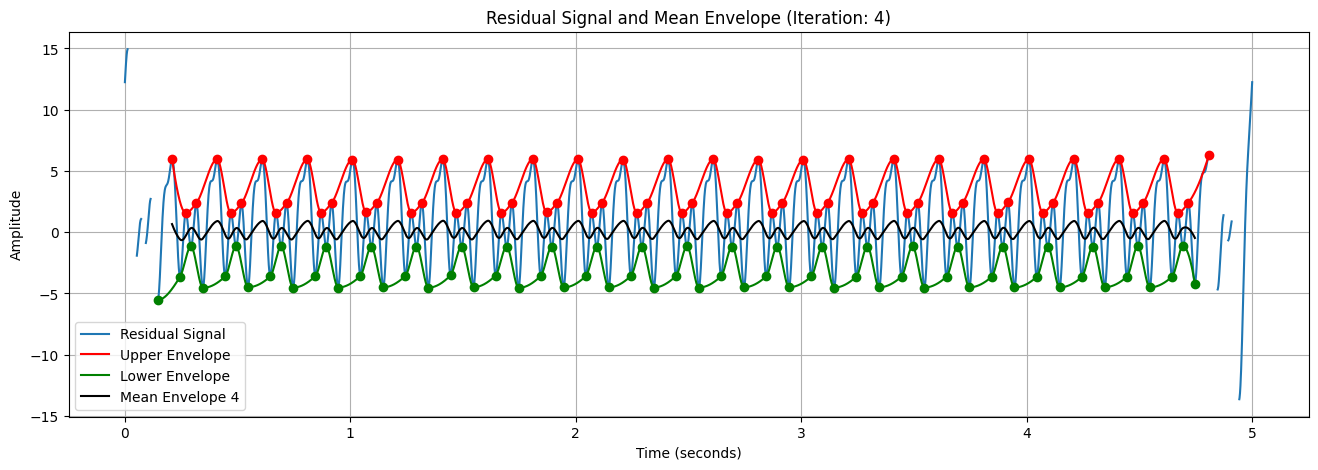

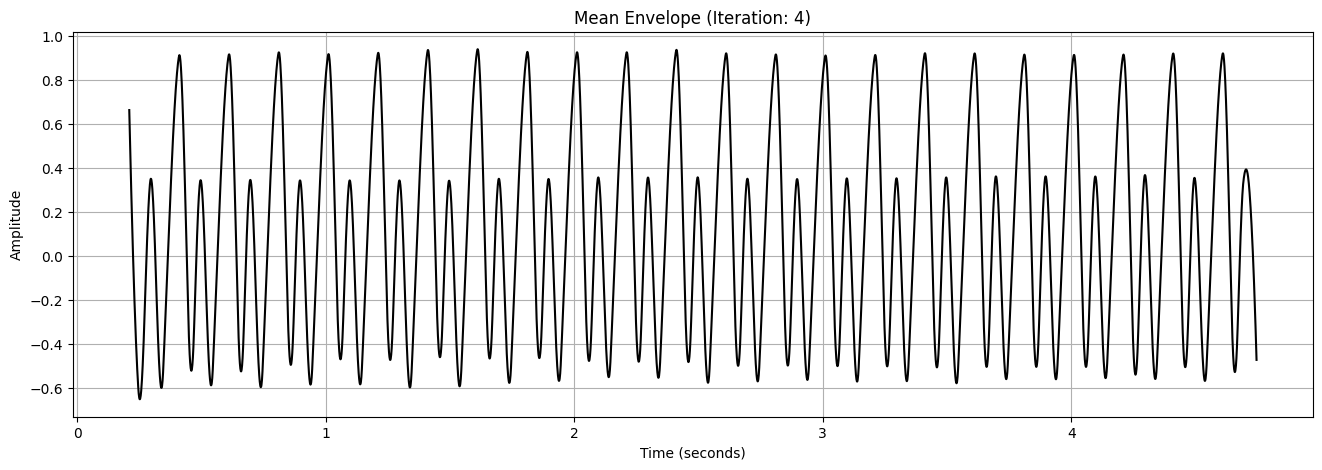

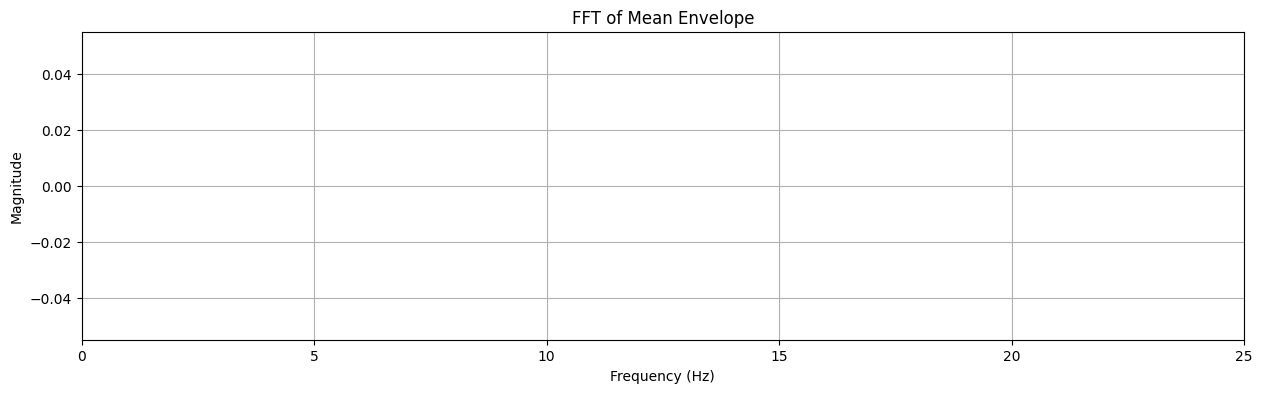


Extrema: 140, Zero Crossings: 144
Max Mean Envelope Amplitude: nan
IMF Condition 1: False, IMF Condition 2: False

IMF conditions have not been met...

---------------------------

---- Sift iteration: 5 ----



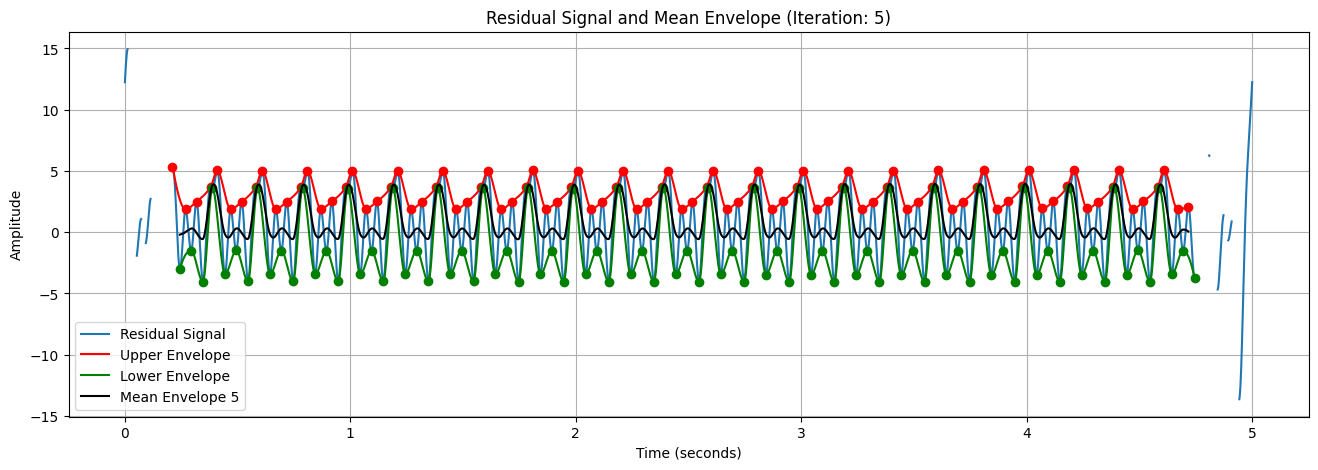

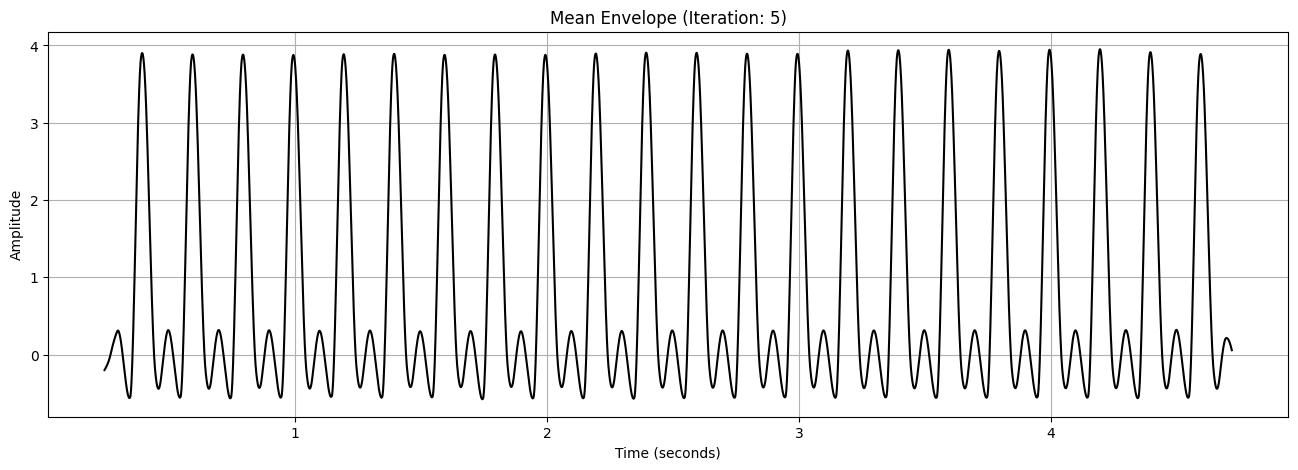

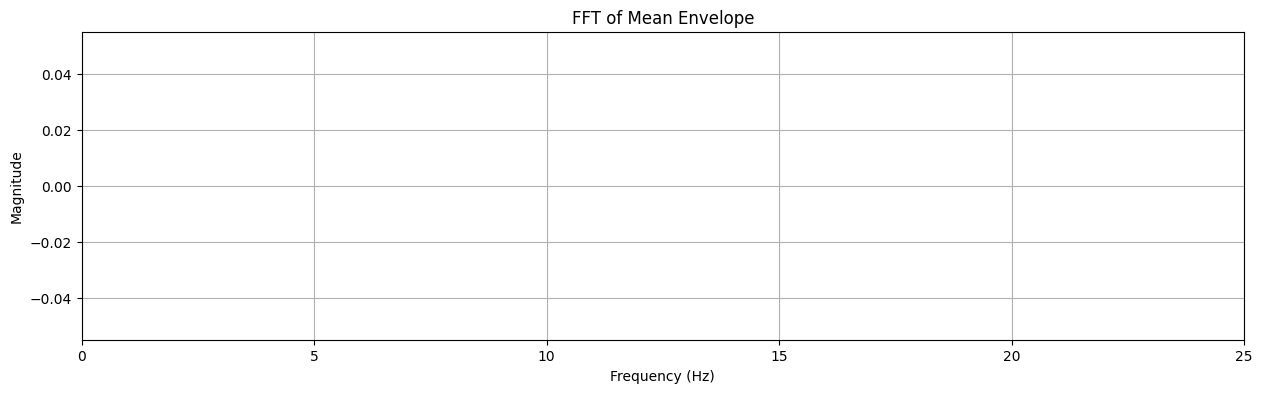


Extrema: 182, Zero Crossings: 142
Max Mean Envelope Amplitude: nan
IMF Condition 1: False, IMF Condition 2: False

IMF conditions have not been met...

---------------------------

Reached max iterations. Returning best effort IMF 1.


---------------------------


=============== Extraction of IMF 2 ===============

---- Sift iteration: 1 ----



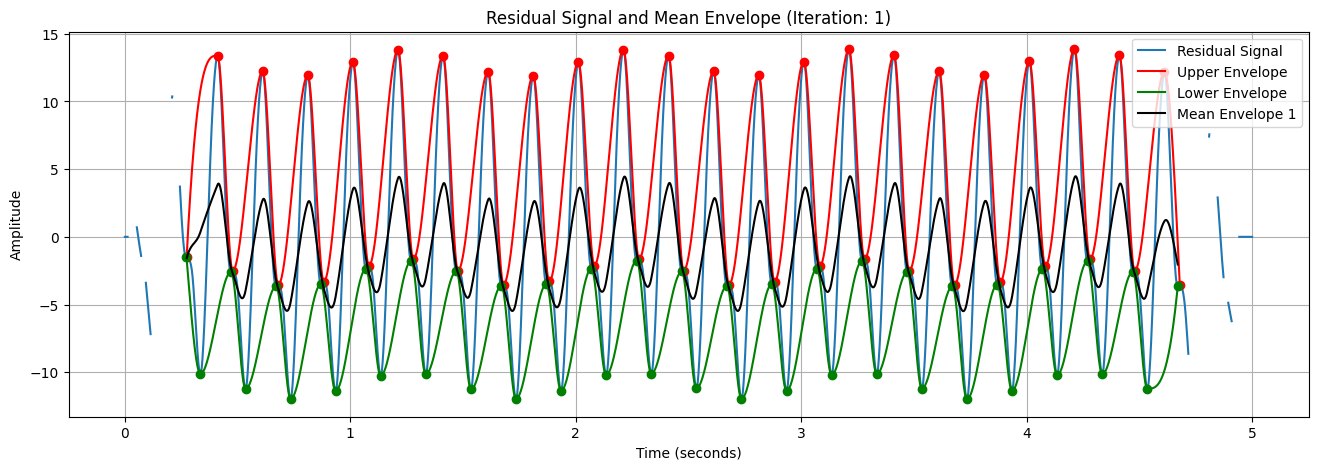

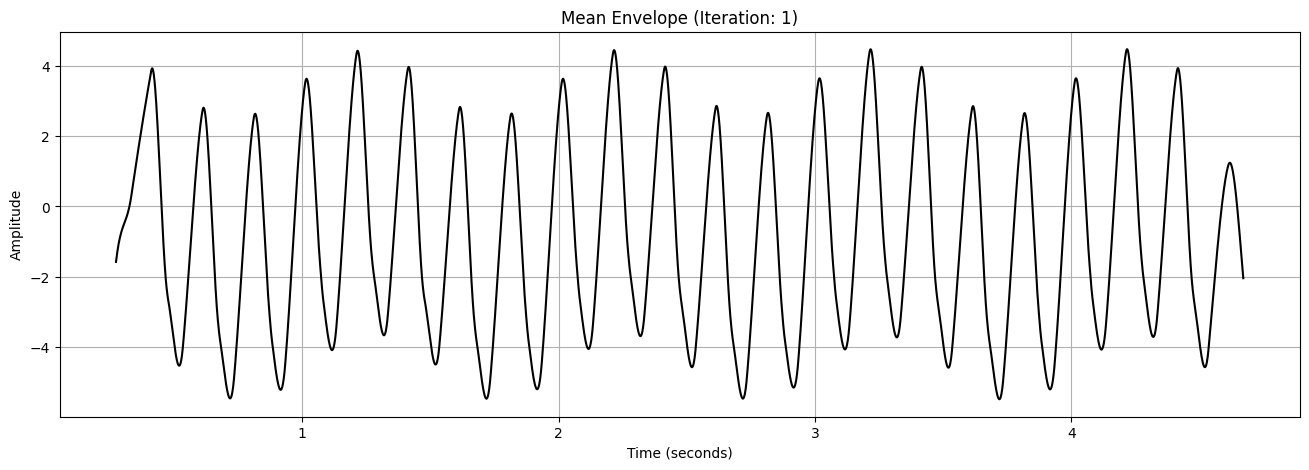

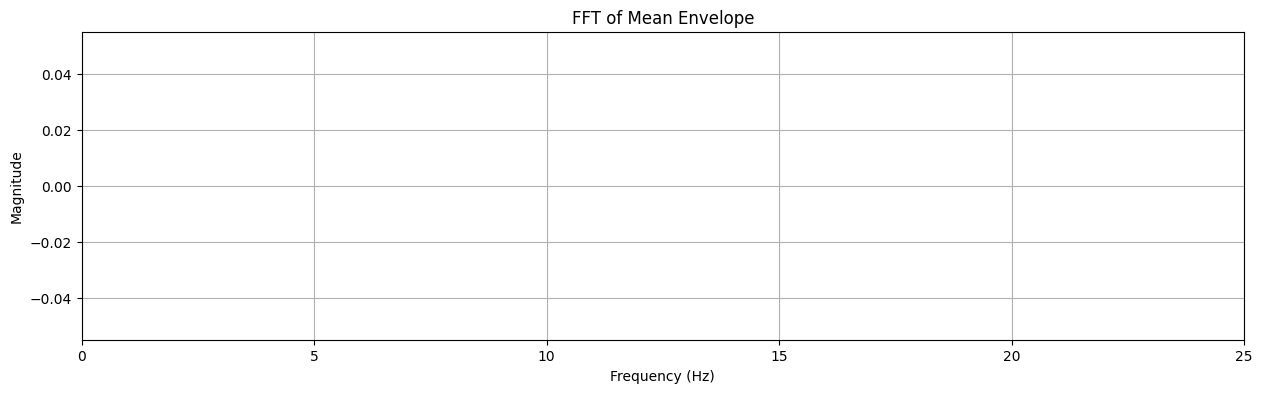


Extrema: 90, Zero Crossings: 47
Max Mean Envelope Amplitude: nan
IMF Condition 1: False, IMF Condition 2: False

IMF conditions have not been met...

---------------------------

---- Sift iteration: 2 ----



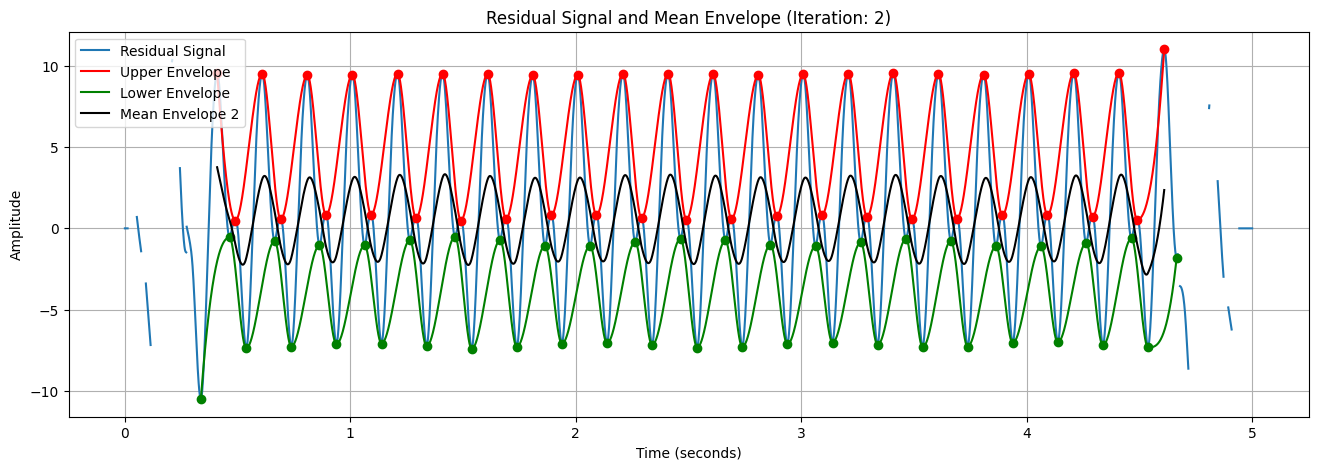

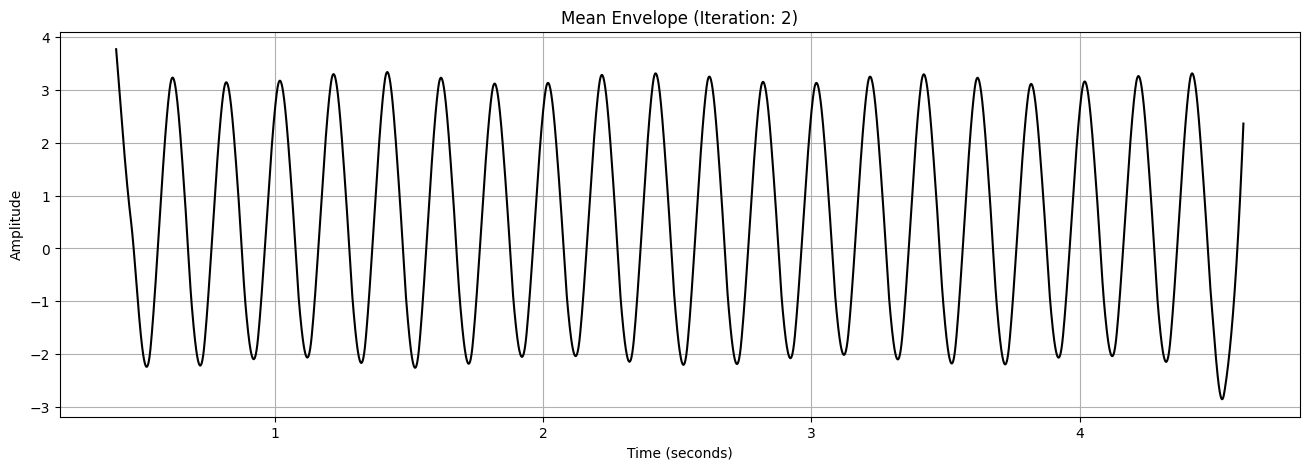

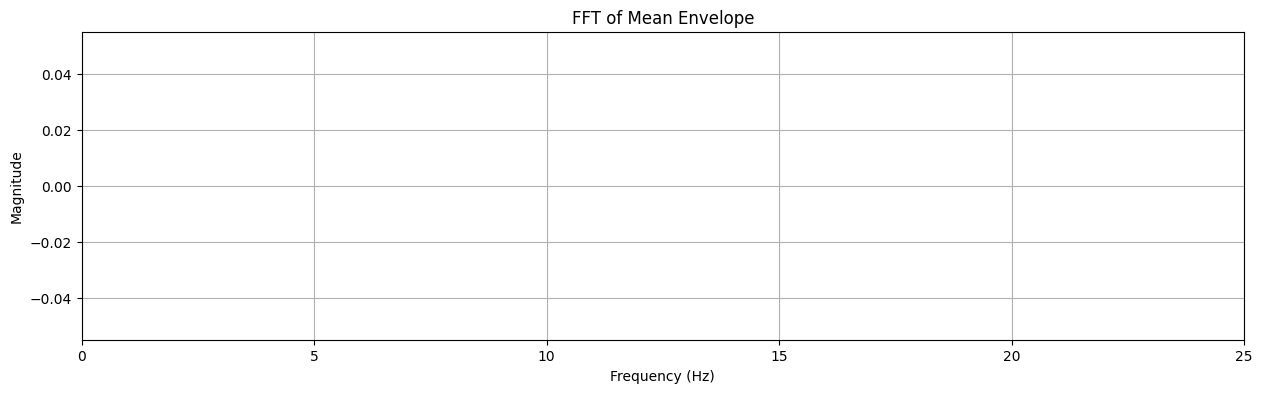


Extrema: 87, Zero Crossings: 90
Max Mean Envelope Amplitude: nan
IMF Condition 1: False, IMF Condition 2: False

IMF conditions have not been met...

---------------------------

---- Sift iteration: 3 ----



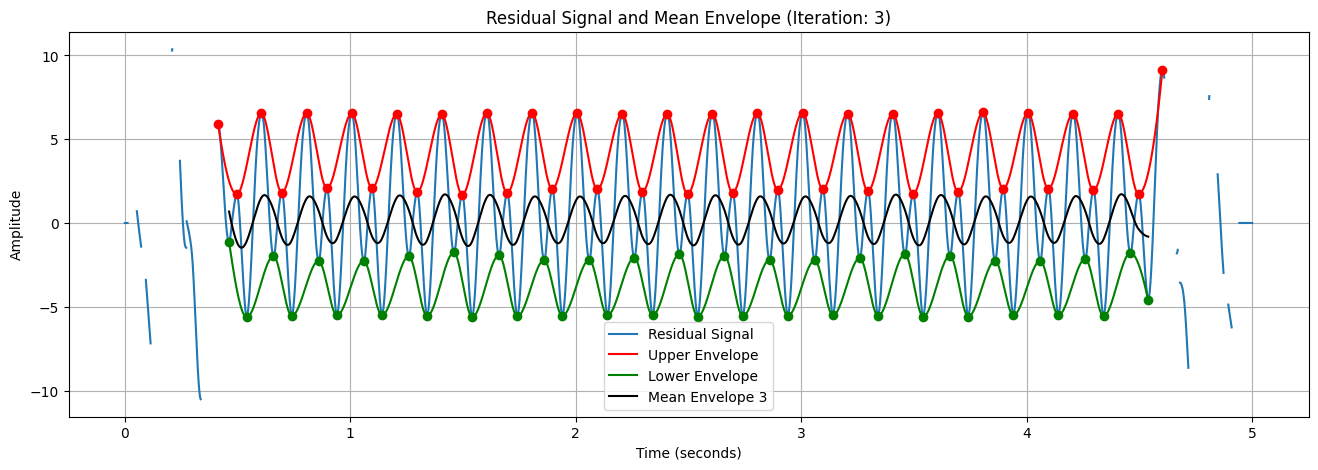

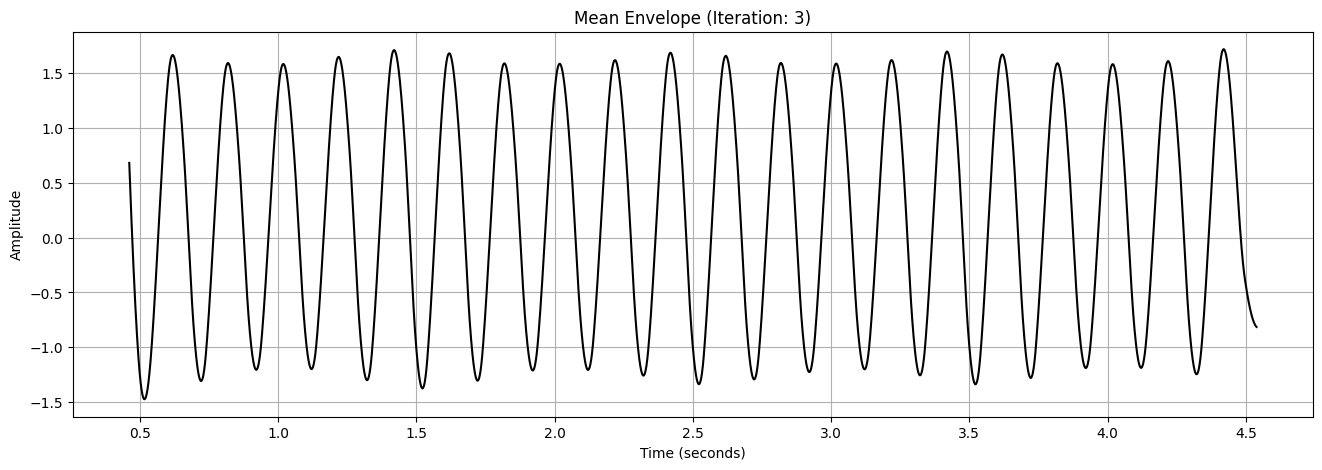

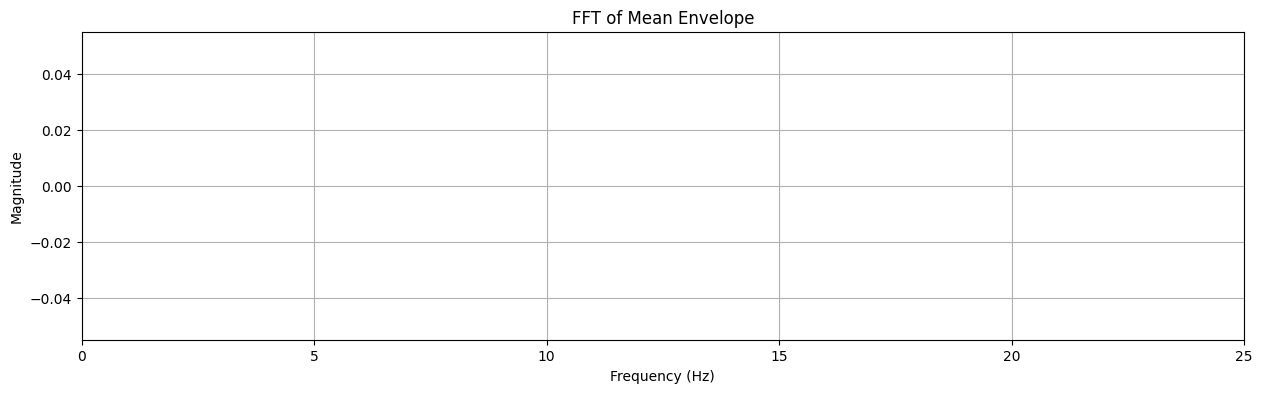


Extrema: 85, Zero Crossings: 88
Max Mean Envelope Amplitude: nan
IMF Condition 1: False, IMF Condition 2: False

IMF conditions have not been met...

---------------------------

---- Sift iteration: 4 ----



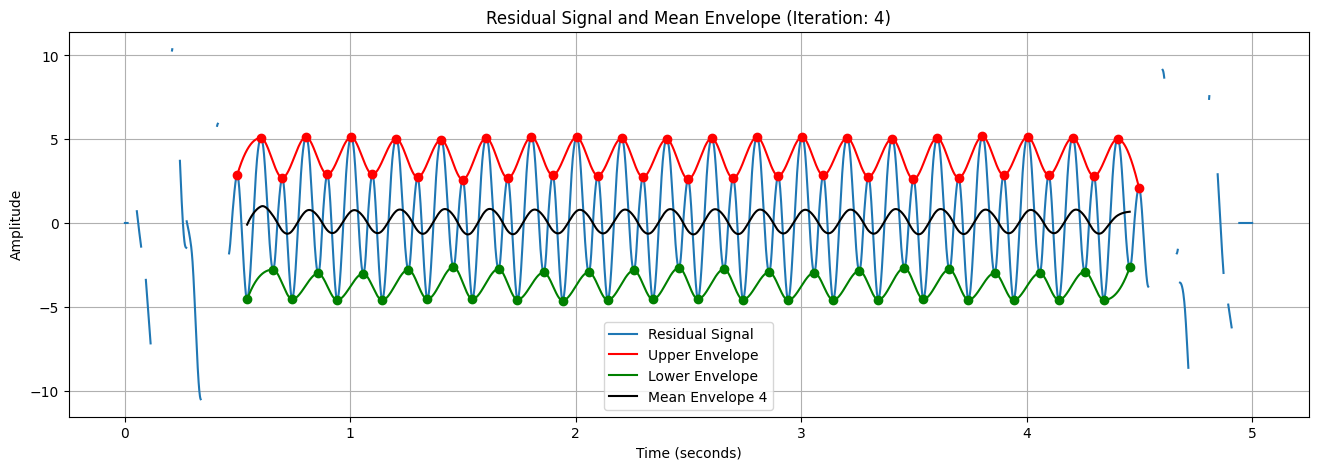

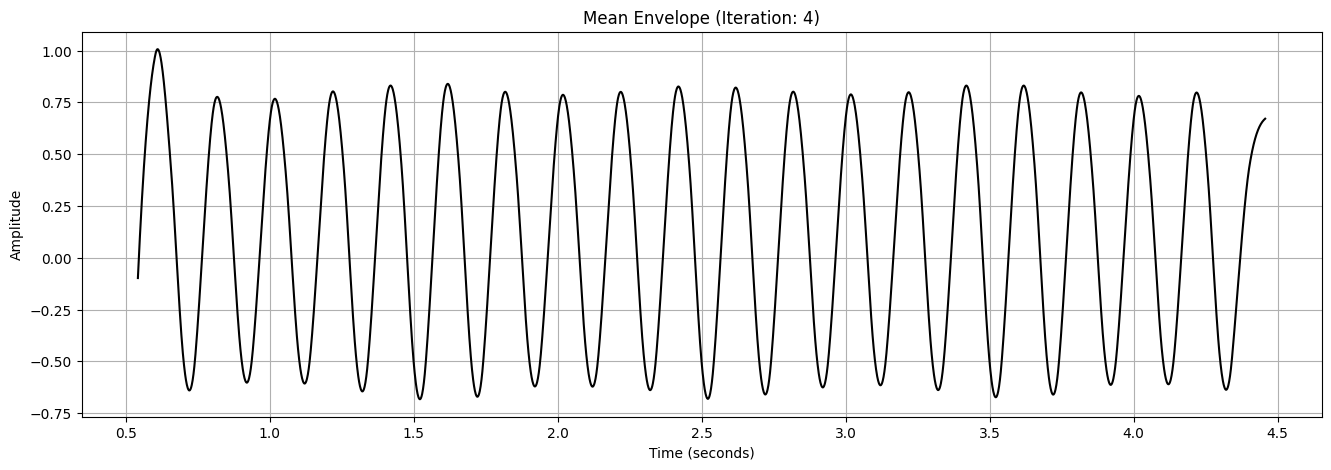

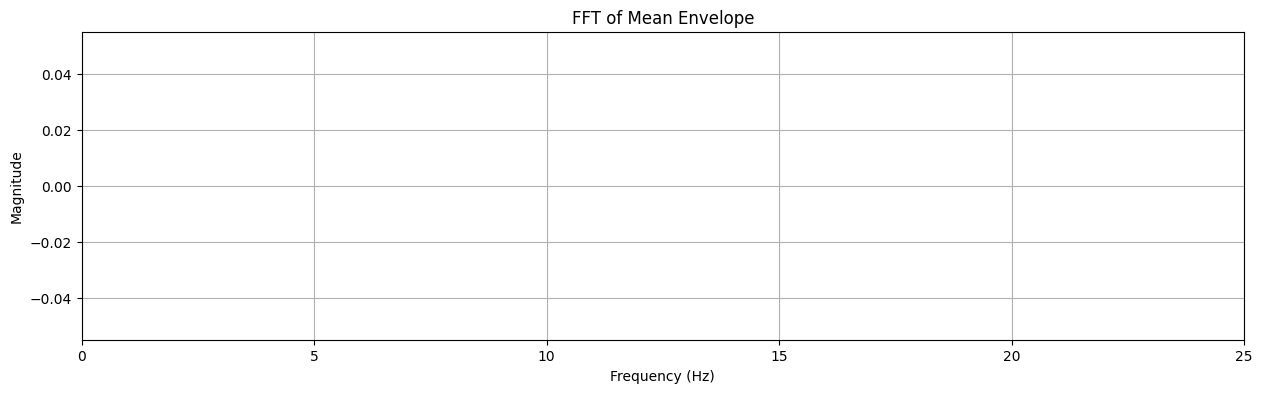


Extrema: 81, Zero Crossings: 86
Max Mean Envelope Amplitude: nan
IMF Condition 1: False, IMF Condition 2: False

IMF conditions have not been met...

---------------------------

---- Sift iteration: 5 ----



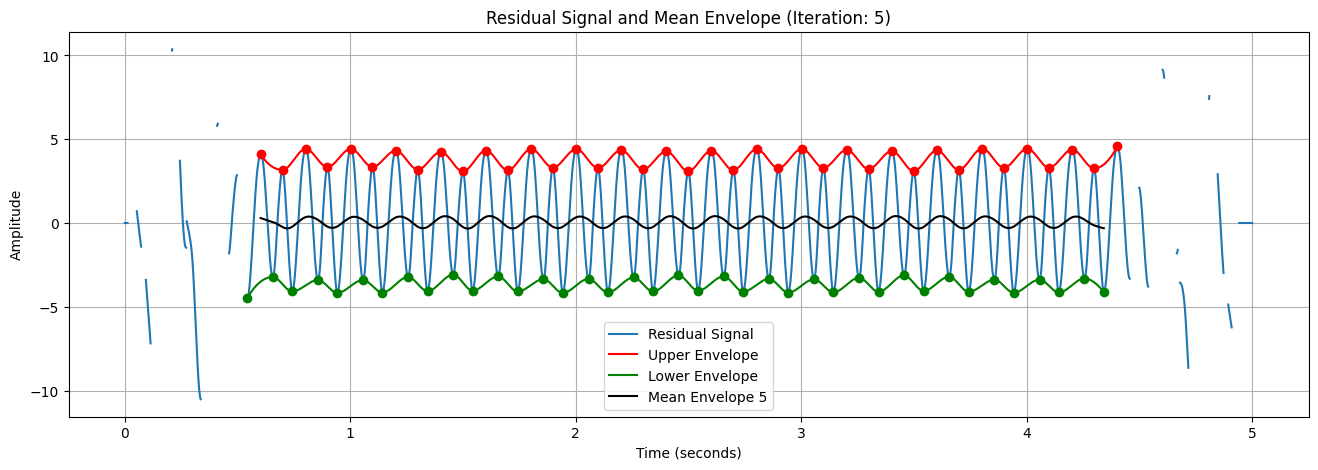

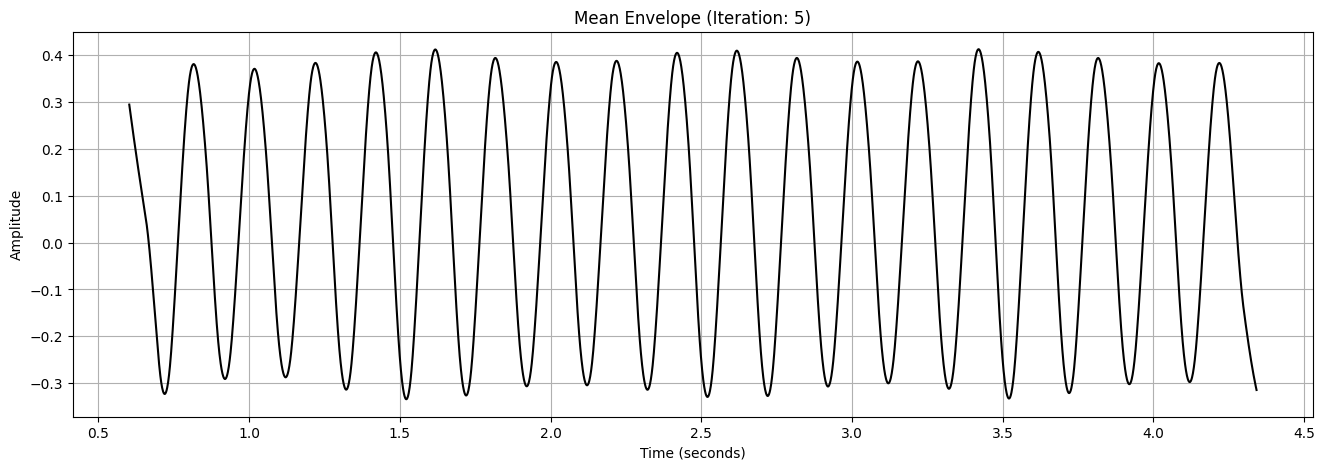

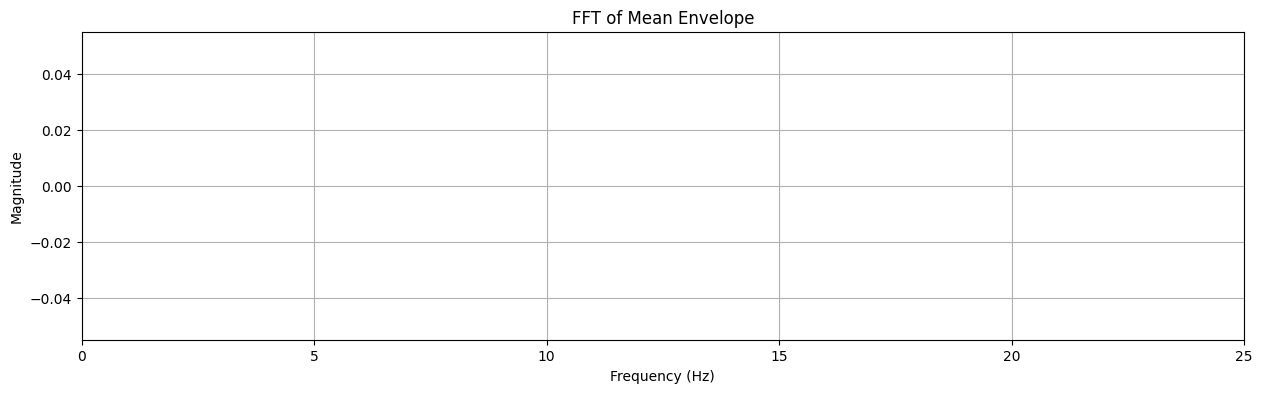


Extrema: 78, Zero Crossings: 84
Max Mean Envelope Amplitude: nan
IMF Condition 1: False, IMF Condition 2: False

IMF conditions have not been met...

---------------------------

Reached max iterations. Returning best effort IMF 2.


---------------------------


=============== Extraction of IMF 3 ===============

---- Sift iteration: 1 ----



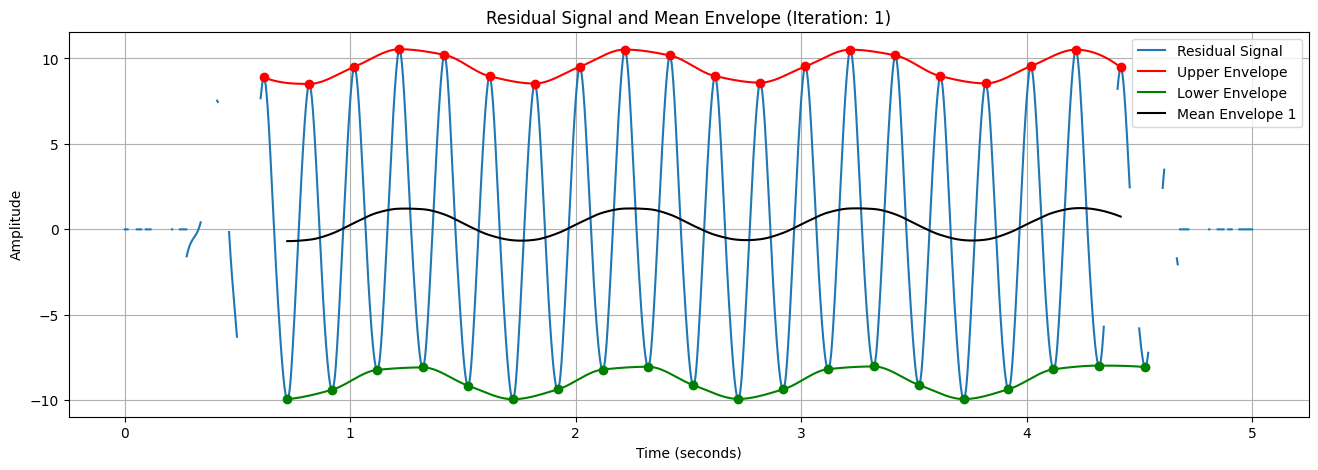

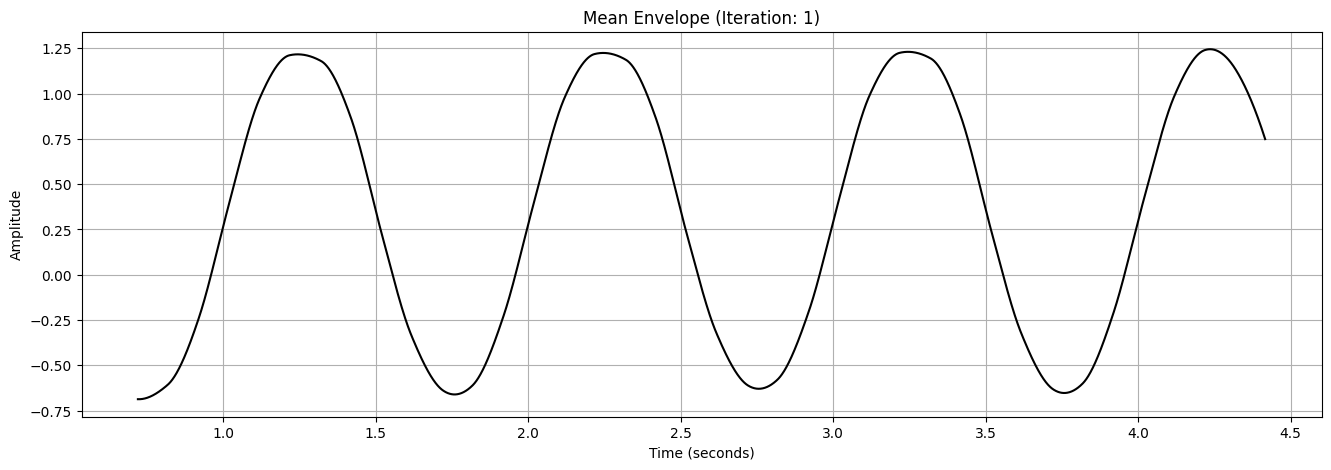

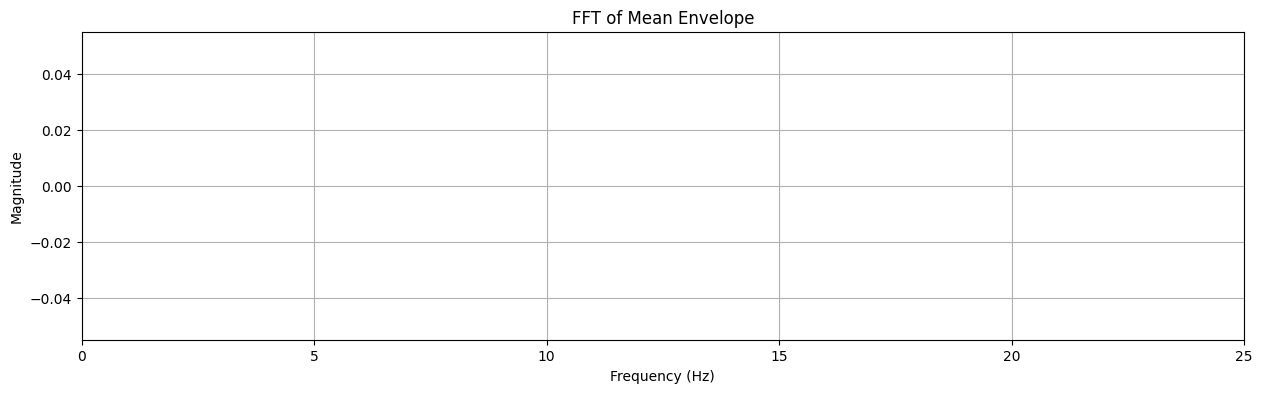


Extrema: 40, Zero Crossings: 38
Max Mean Envelope Amplitude: nan
IMF Condition 1: False, IMF Condition 2: False

IMF conditions have not been met...

---------------------------

---- Sift iteration: 2 ----



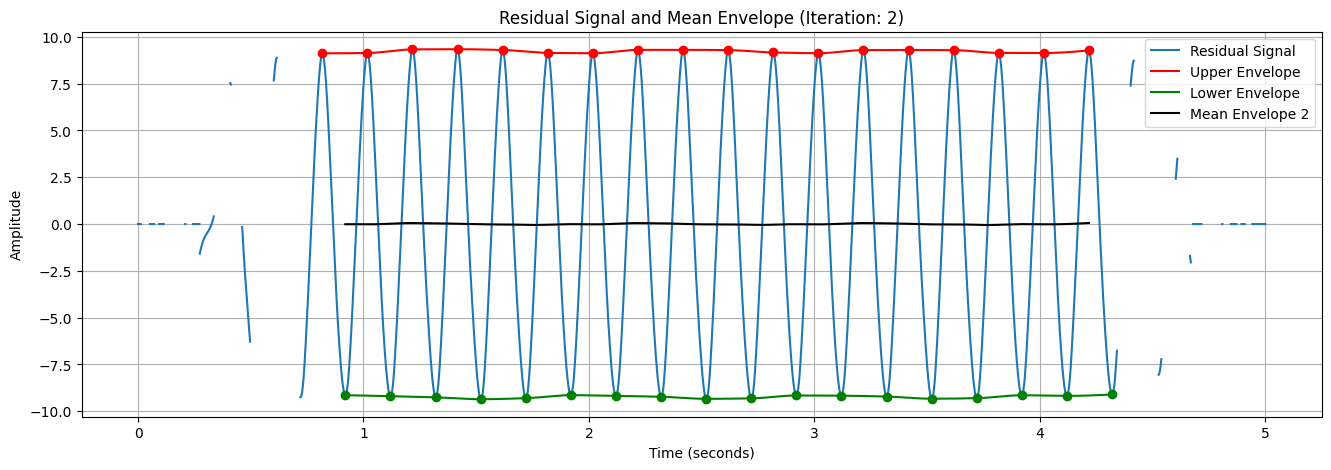

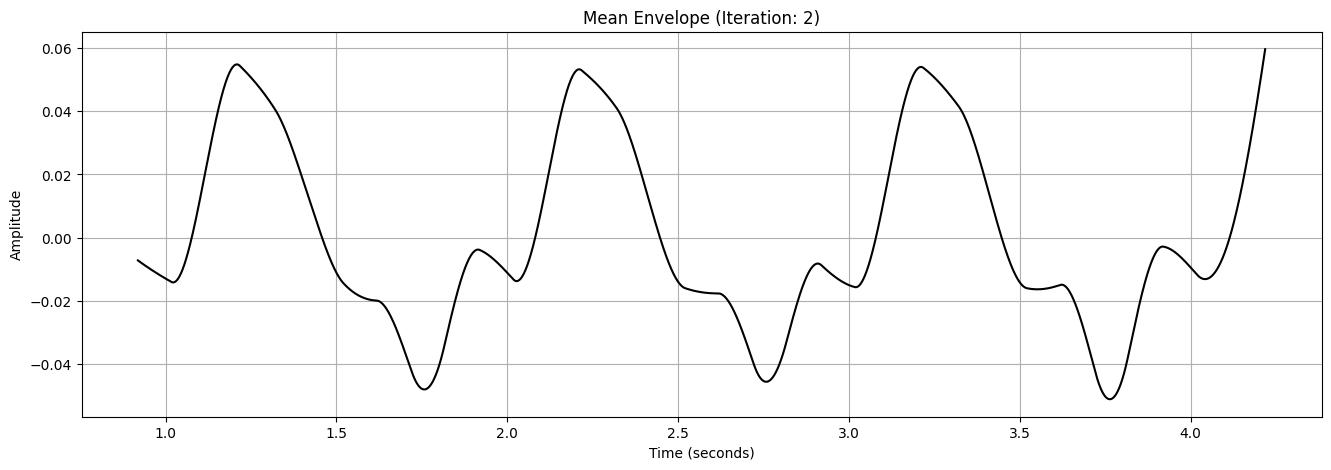

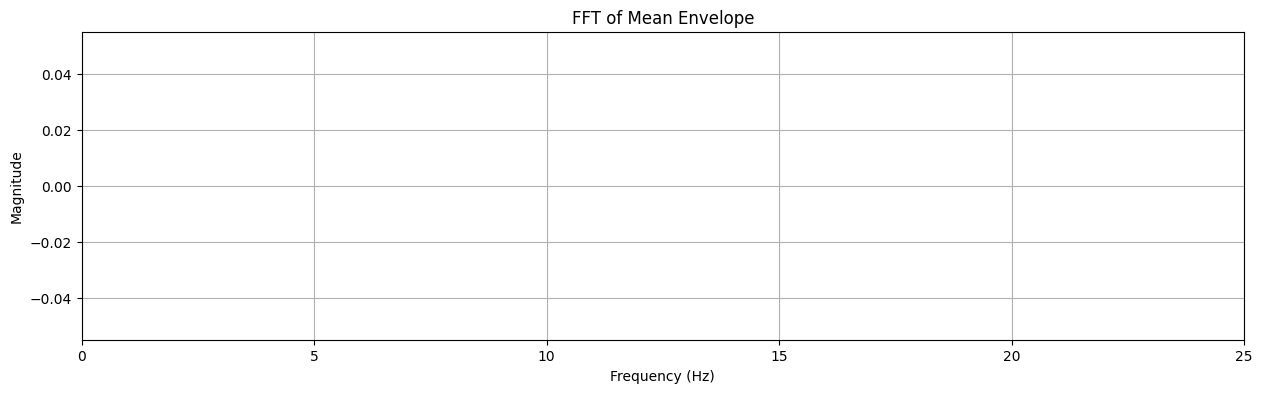


Extrema: 36, Zero Crossings: 37
Max Mean Envelope Amplitude: nan
IMF Condition 1: True, IMF Condition 2: False

IMF conditions have not been met...

---------------------------

---- Sift iteration: 3 ----



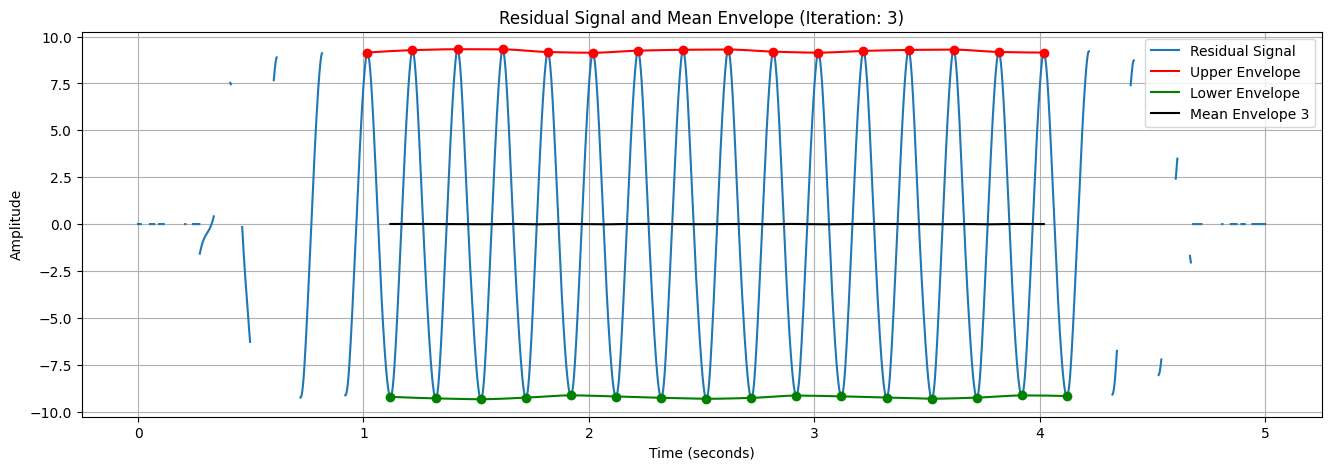

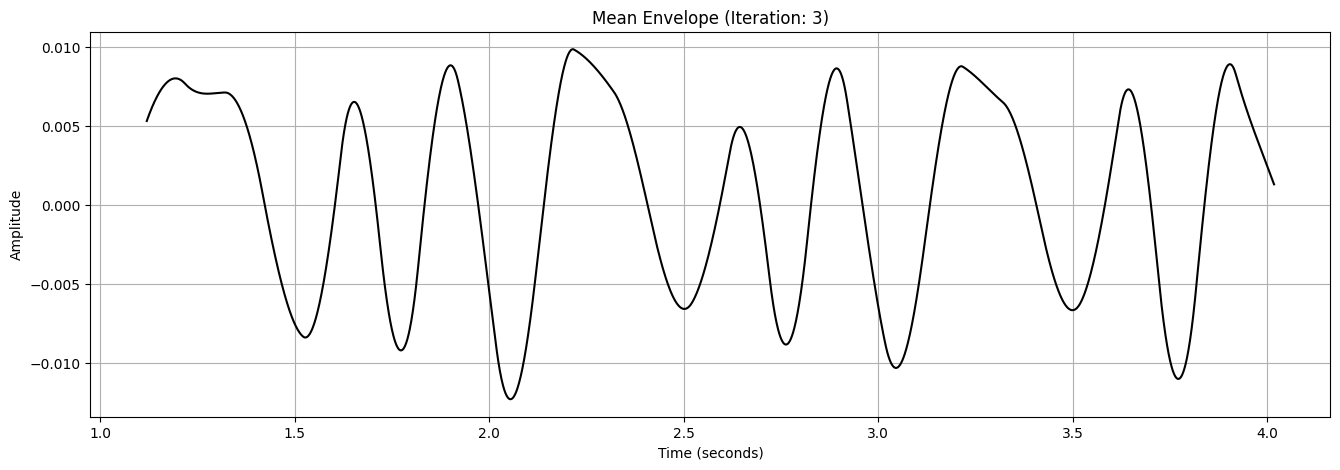

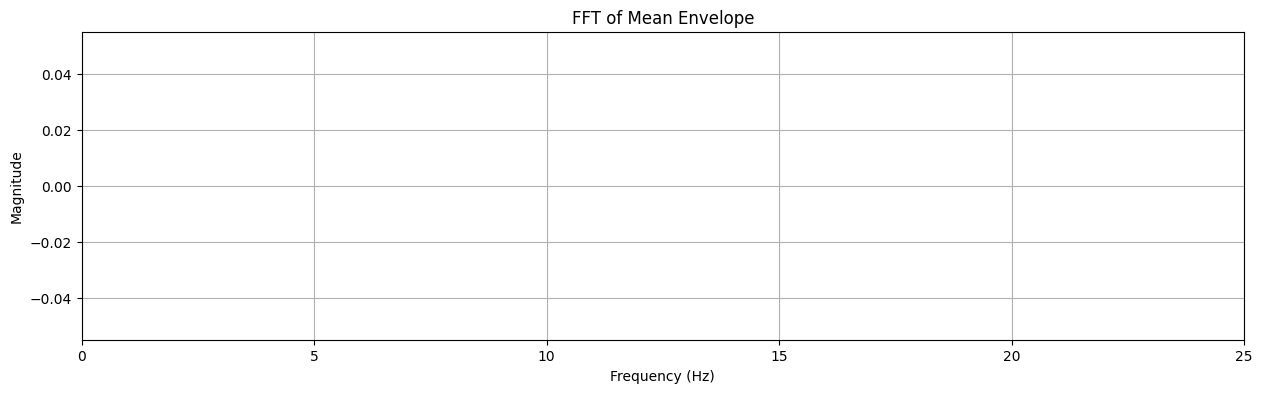


Extrema: 32, Zero Crossings: 35
Max Mean Envelope Amplitude: nan
IMF Condition 1: False, IMF Condition 2: False

IMF conditions have not been met...

---------------------------

---- Sift iteration: 4 ----



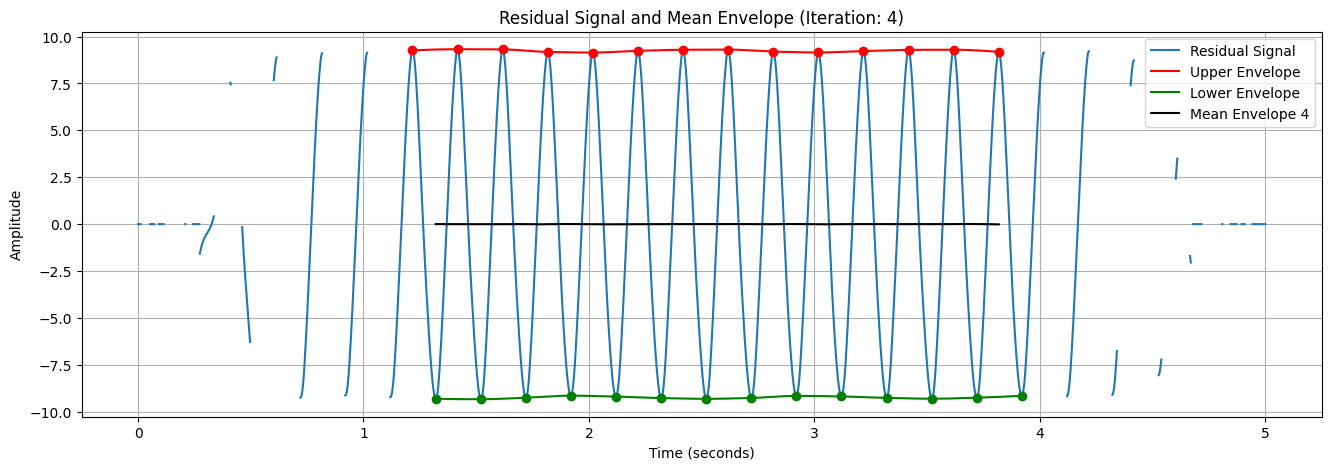

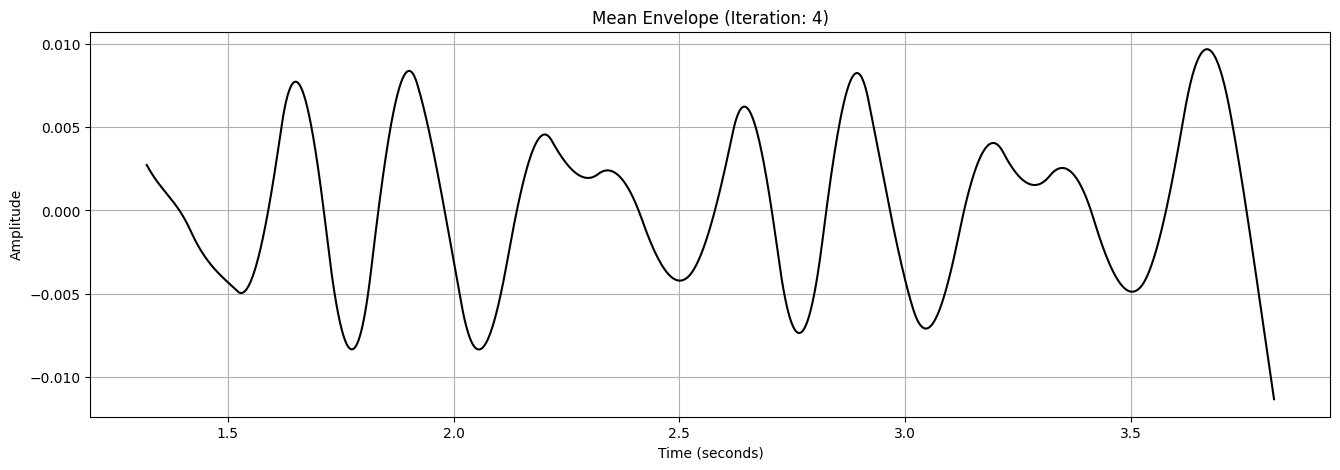

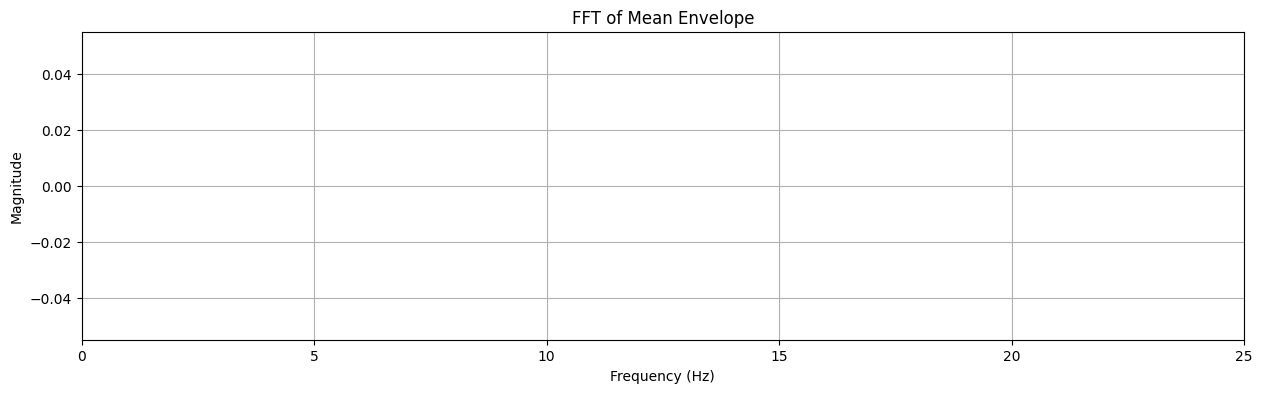


Extrema: 28, Zero Crossings: 33
Max Mean Envelope Amplitude: nan
IMF Condition 1: False, IMF Condition 2: False

IMF conditions have not been met...

---------------------------

---- Sift iteration: 5 ----



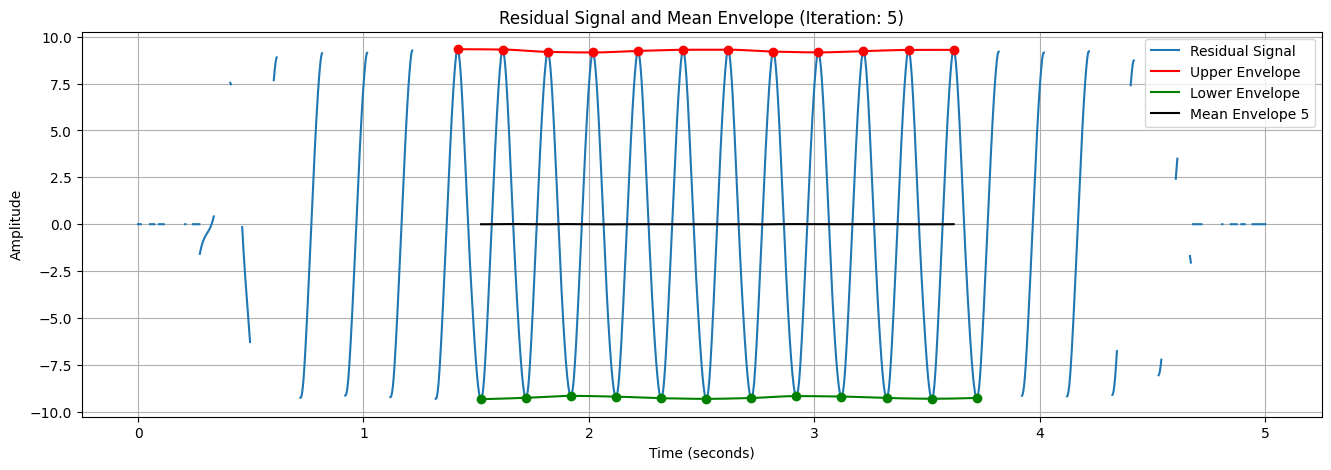

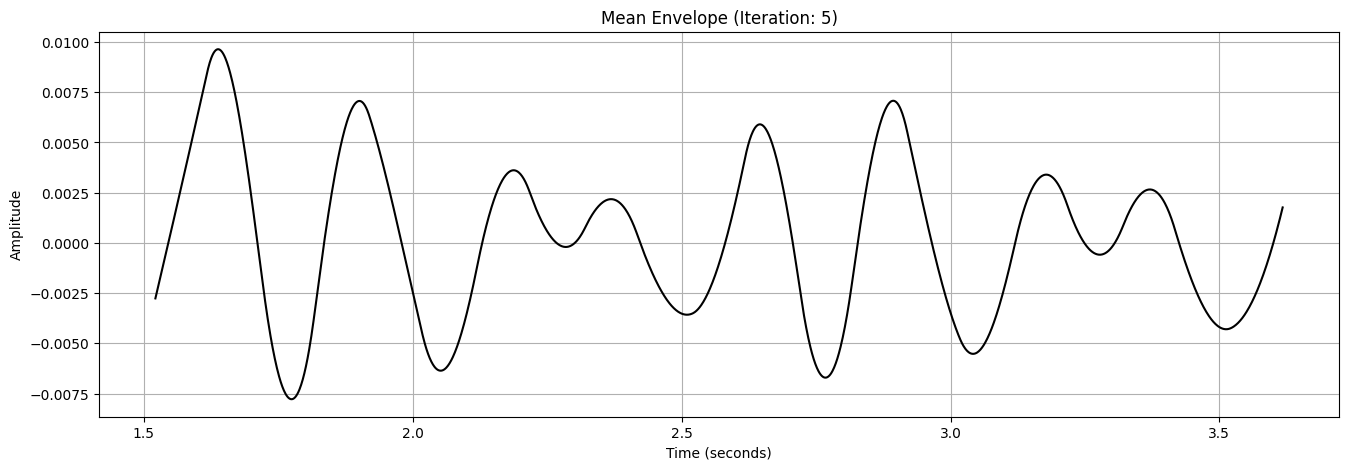

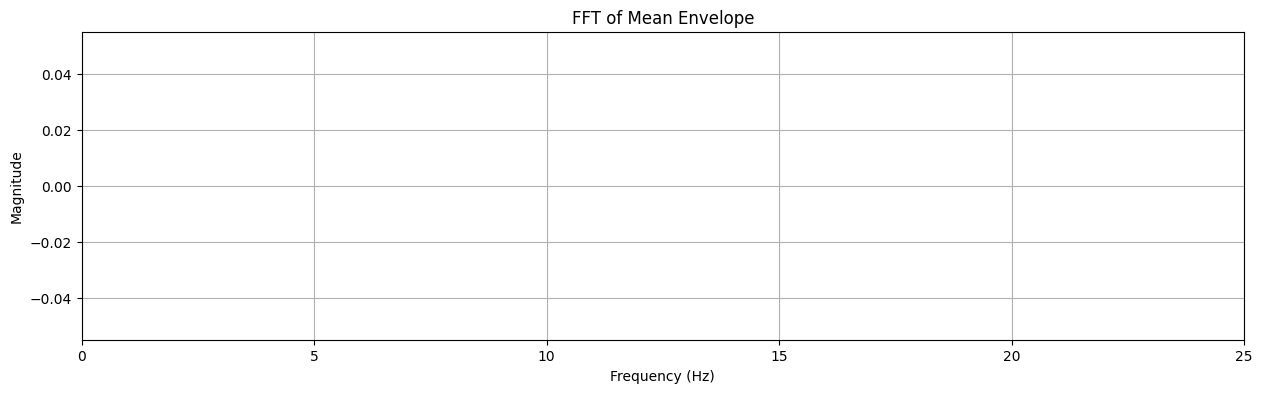


Extrema: 24, Zero Crossings: 31
Max Mean Envelope Amplitude: nan
IMF Condition 1: False, IMF Condition 2: False

IMF conditions have not been met...

---------------------------

Reached max iterations. Returning best effort IMF 3.


---------------------------


=============== Extraction of IMF 4 ===============

---- Sift iteration: 1 ----



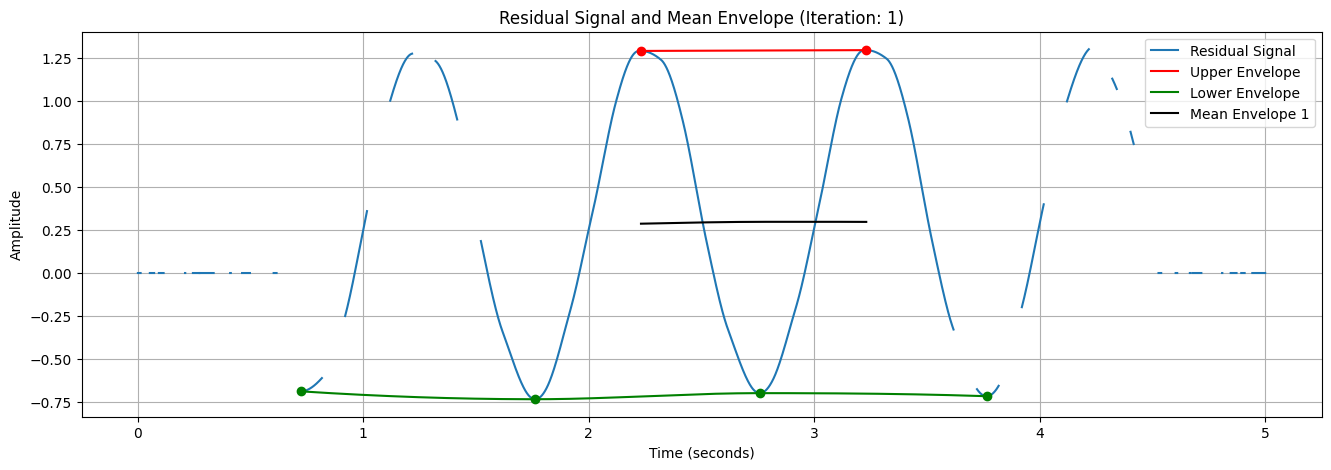

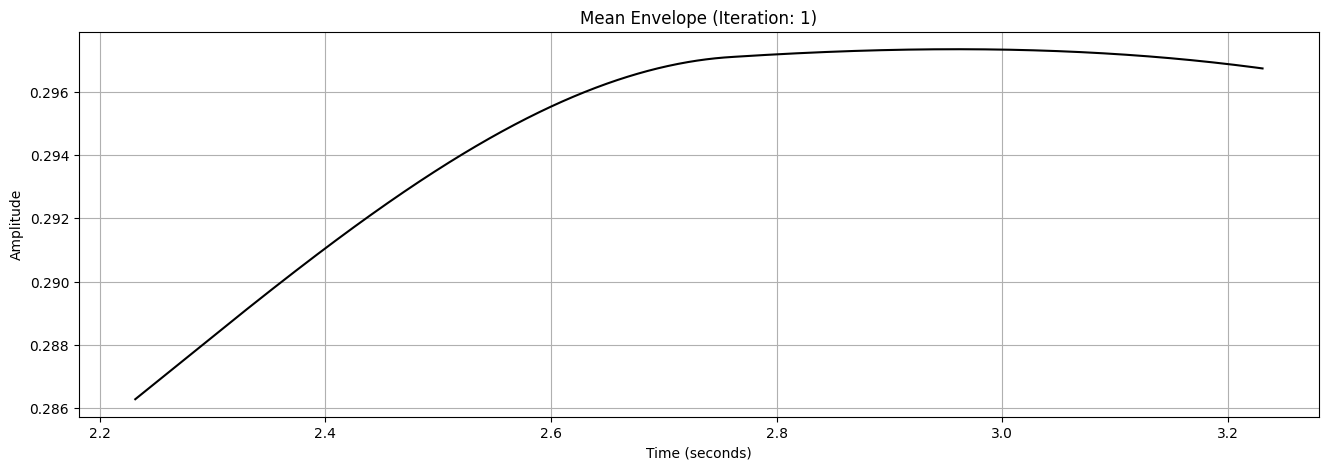

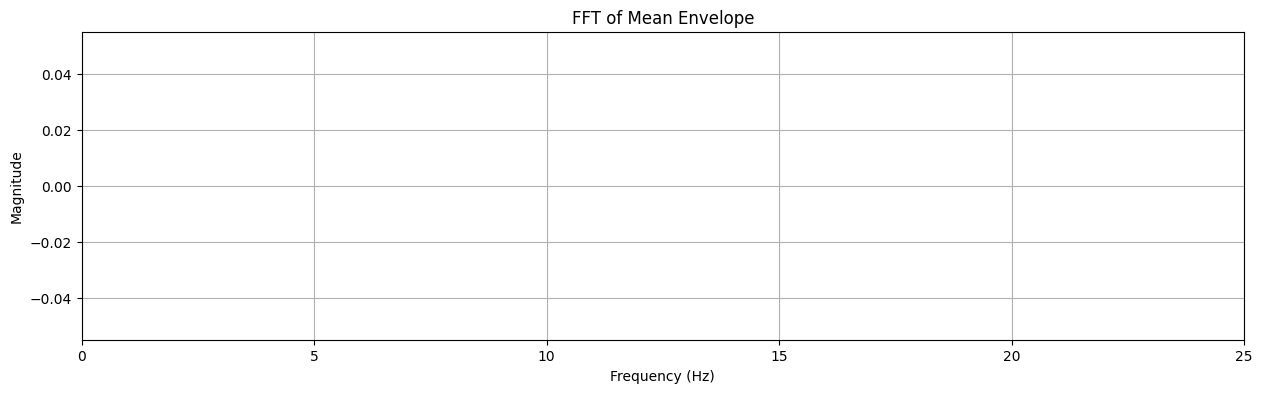


Extrema: 6, Zero Crossings: 7
Max Mean Envelope Amplitude: nan
IMF Condition 1: True, IMF Condition 2: False

IMF conditions have not been met...

---------------------------

---- Sift iteration: 2 ----


Not enough extrema. Ending sift.

---------------------------

Stopping EMD: Residual signal not decomposable.


In [20]:
imfs, _ = emd(t, signal, fs, max_sift_iter=5)

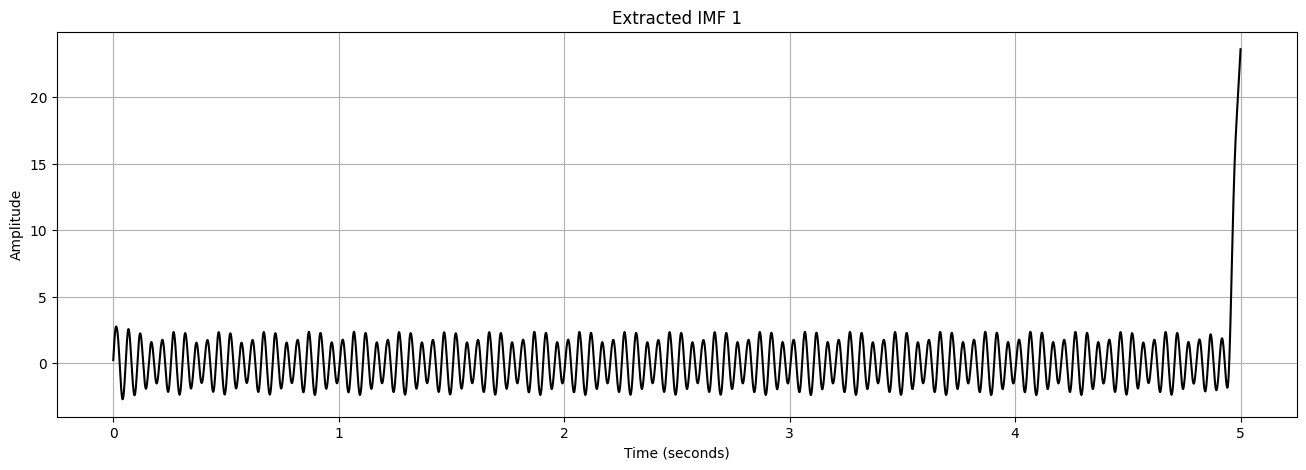

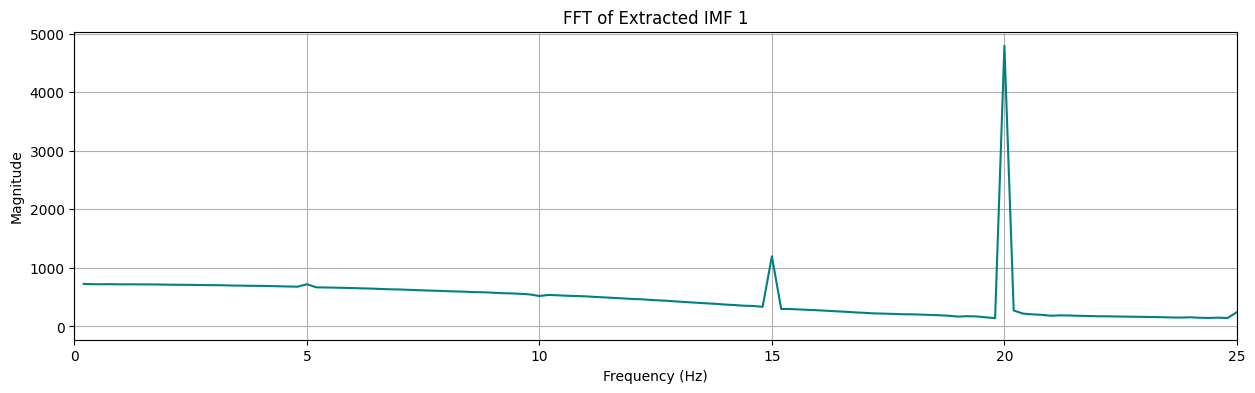

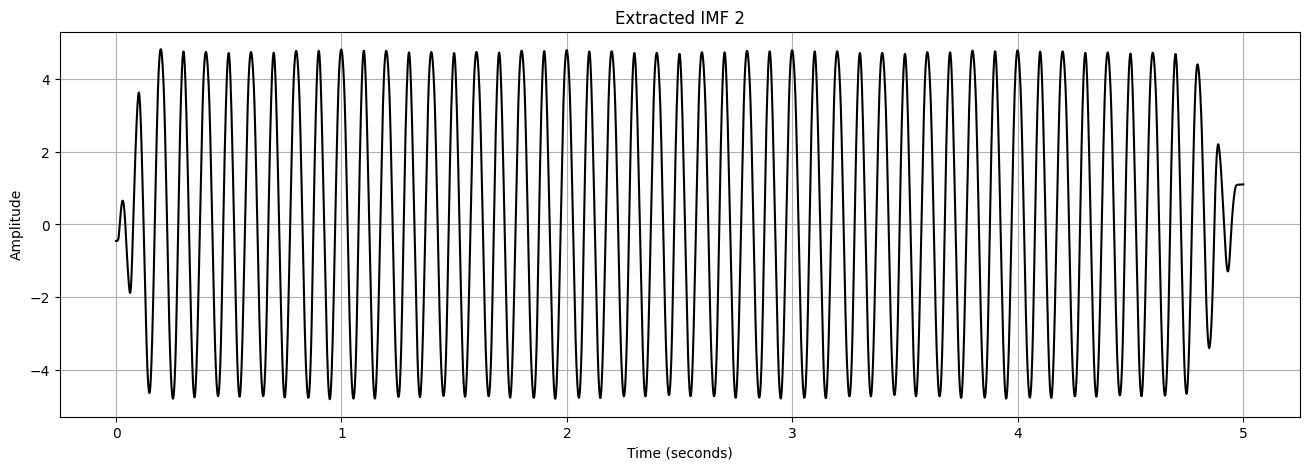

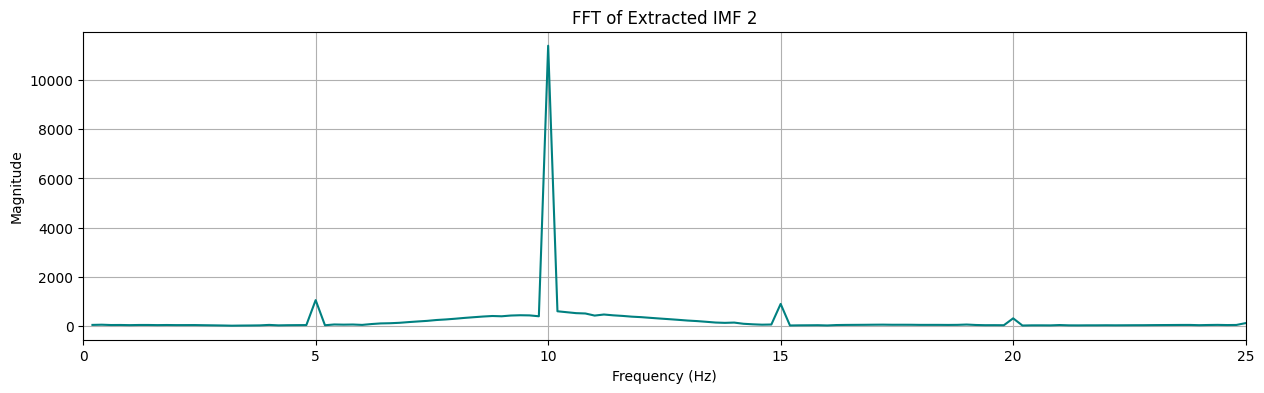

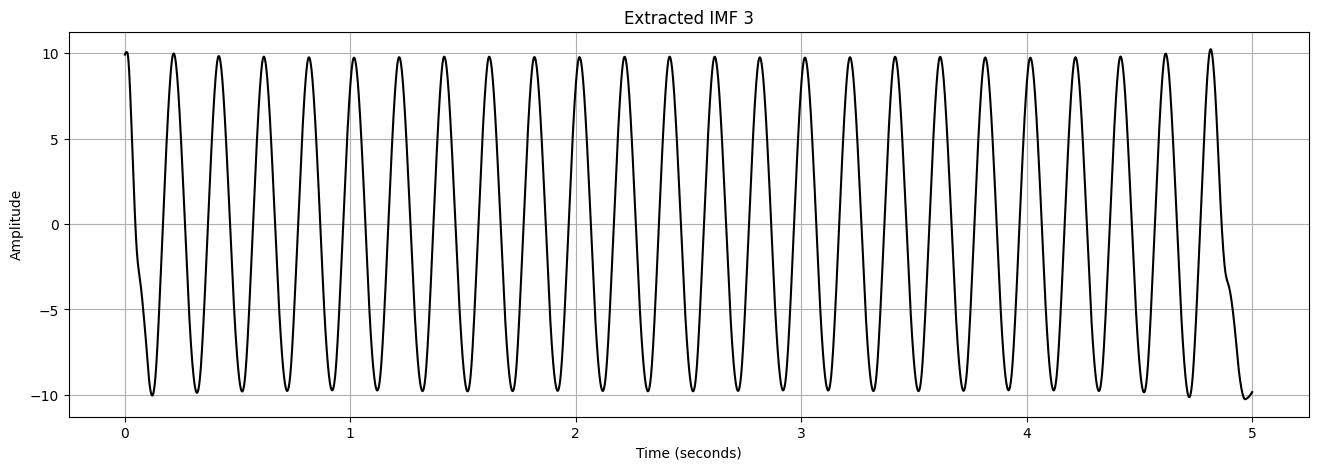

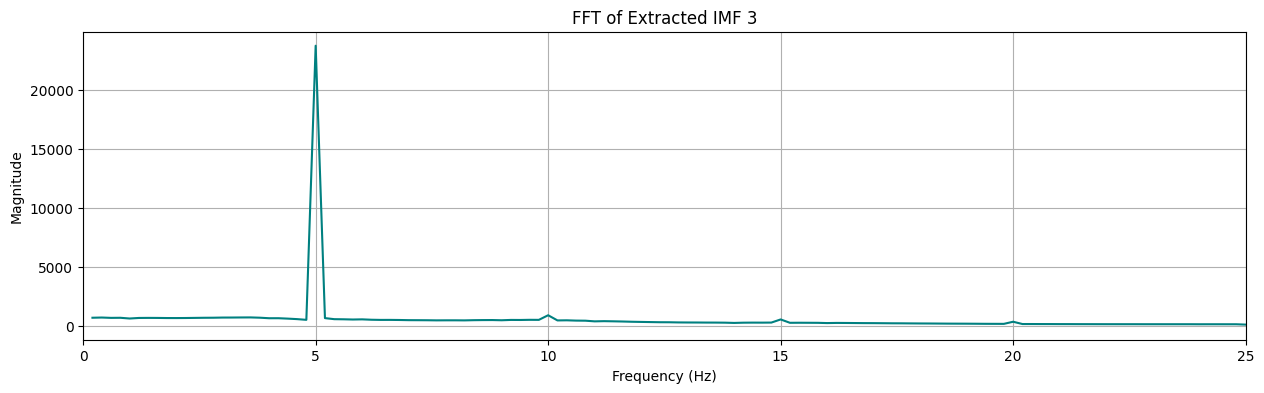

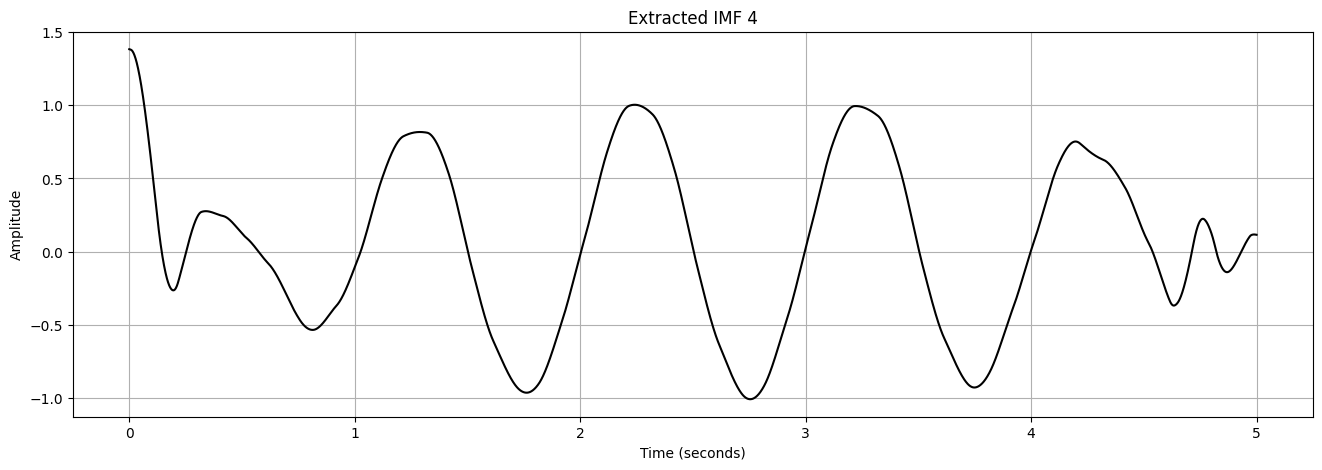

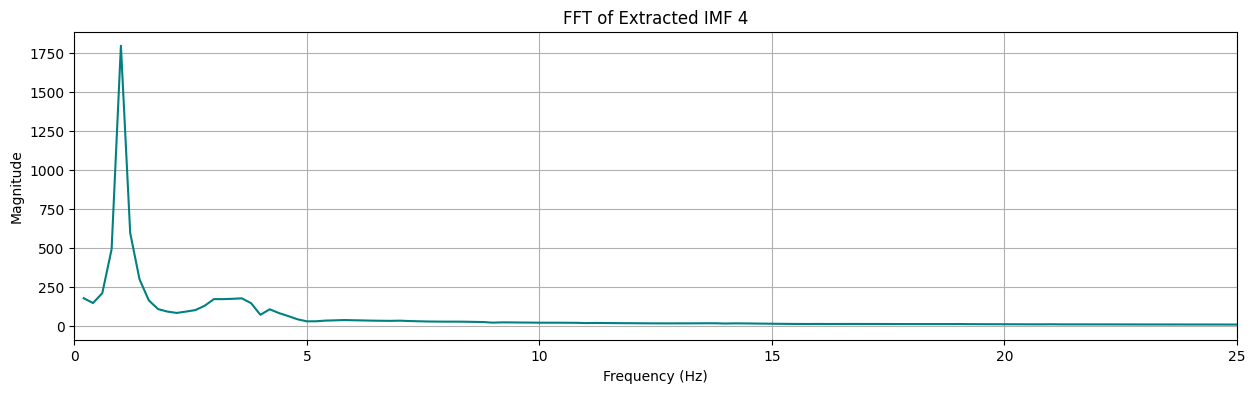

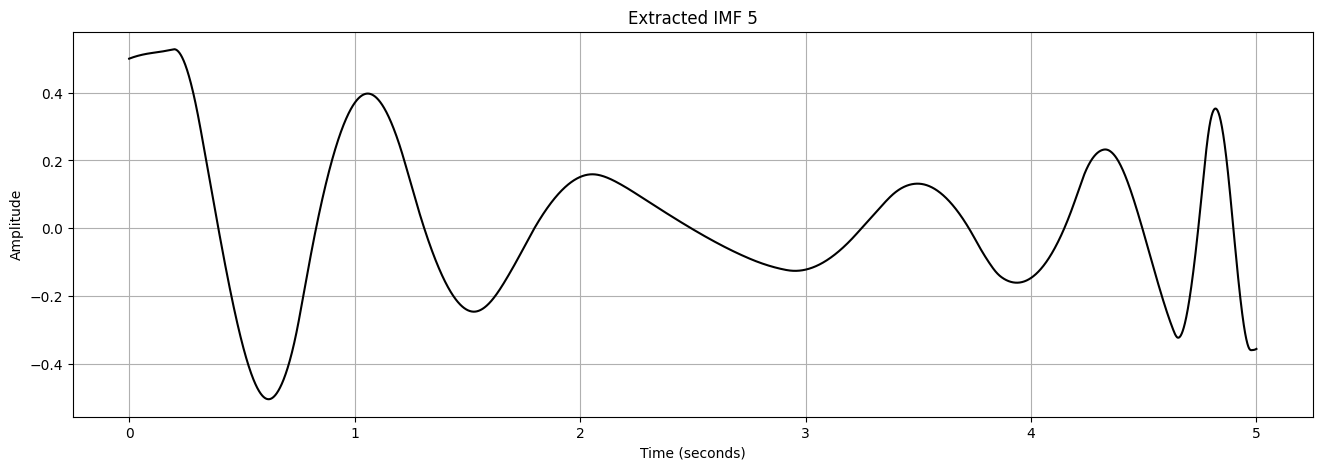

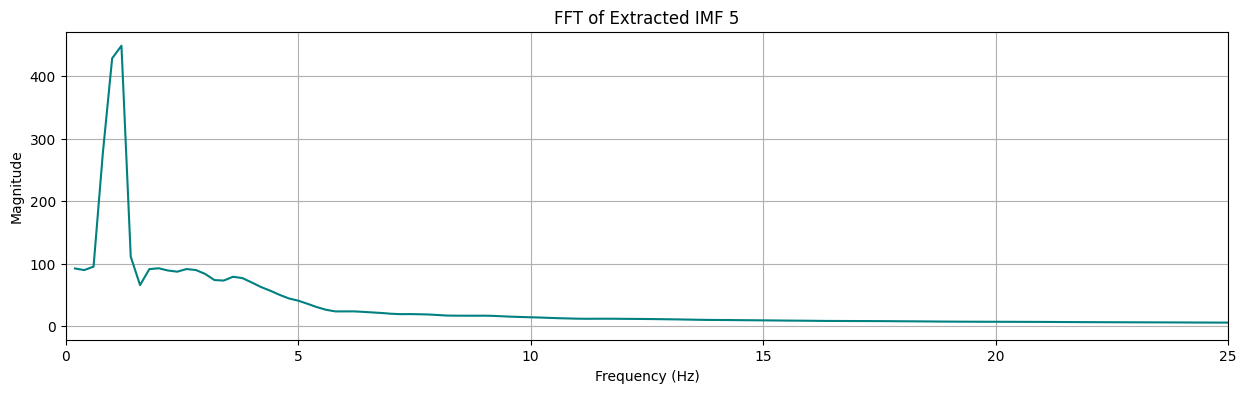

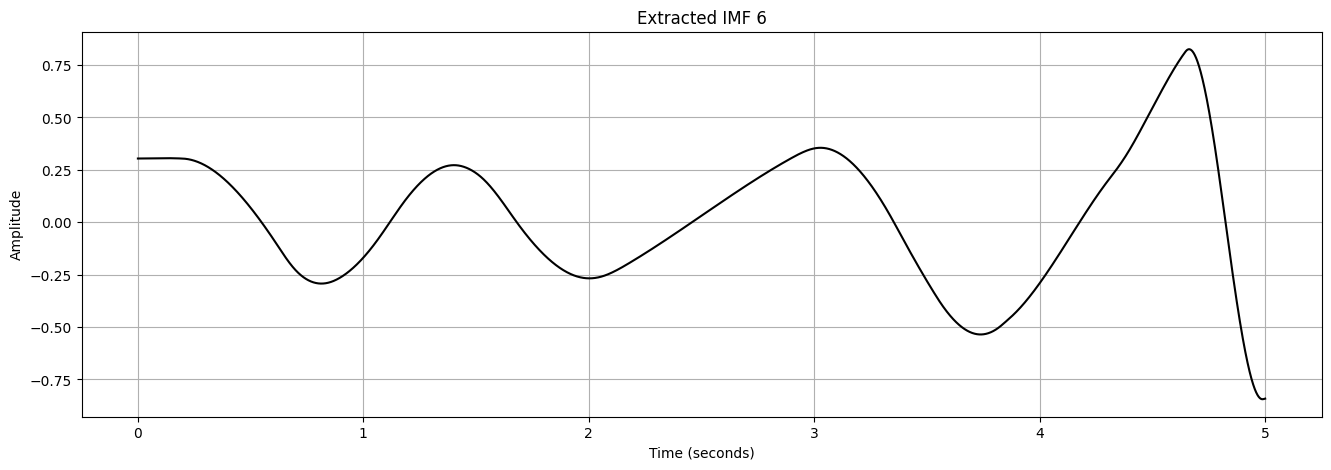

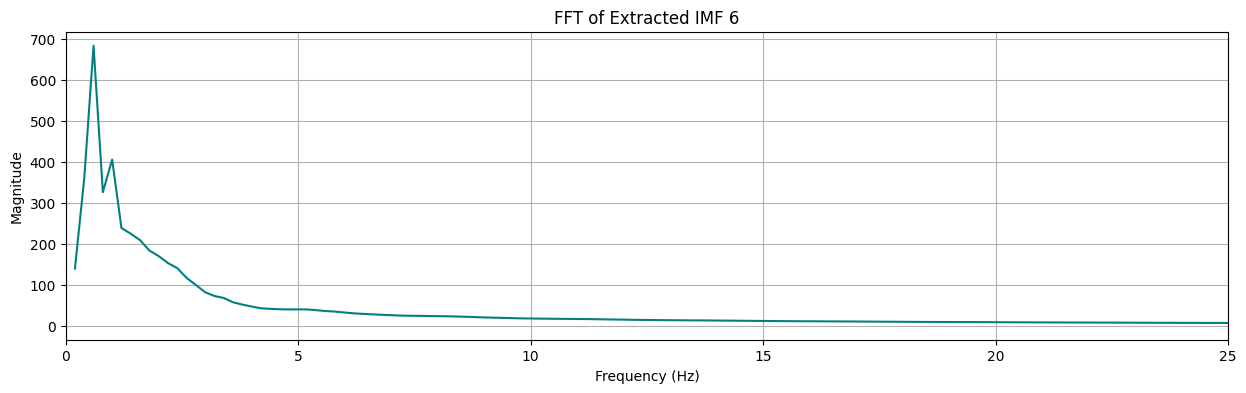

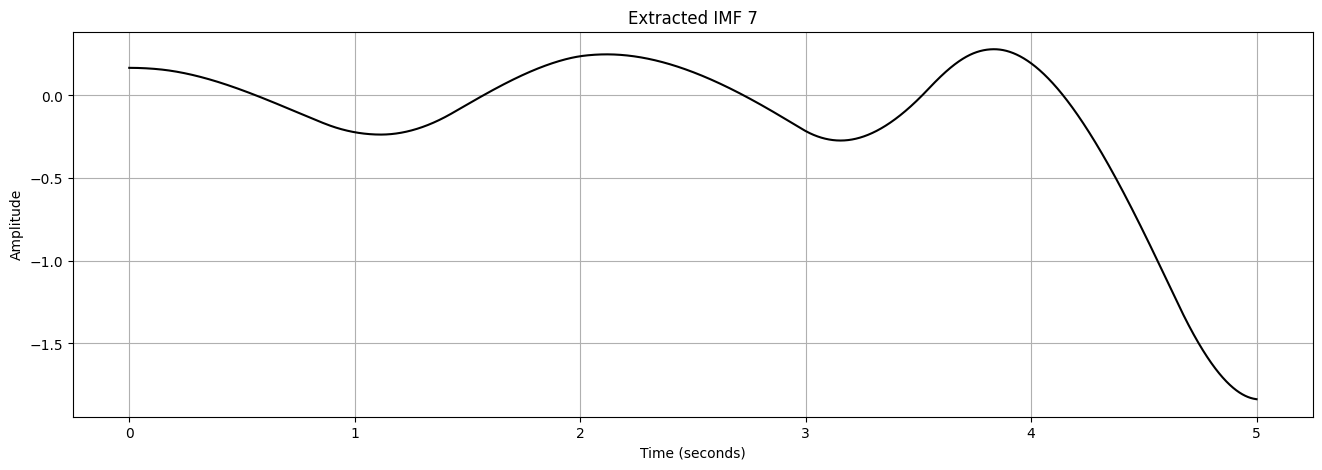

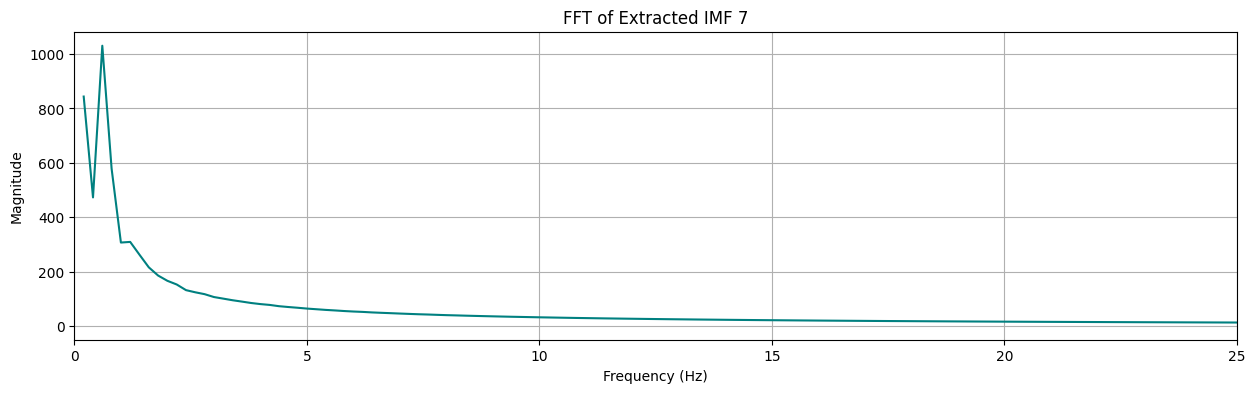

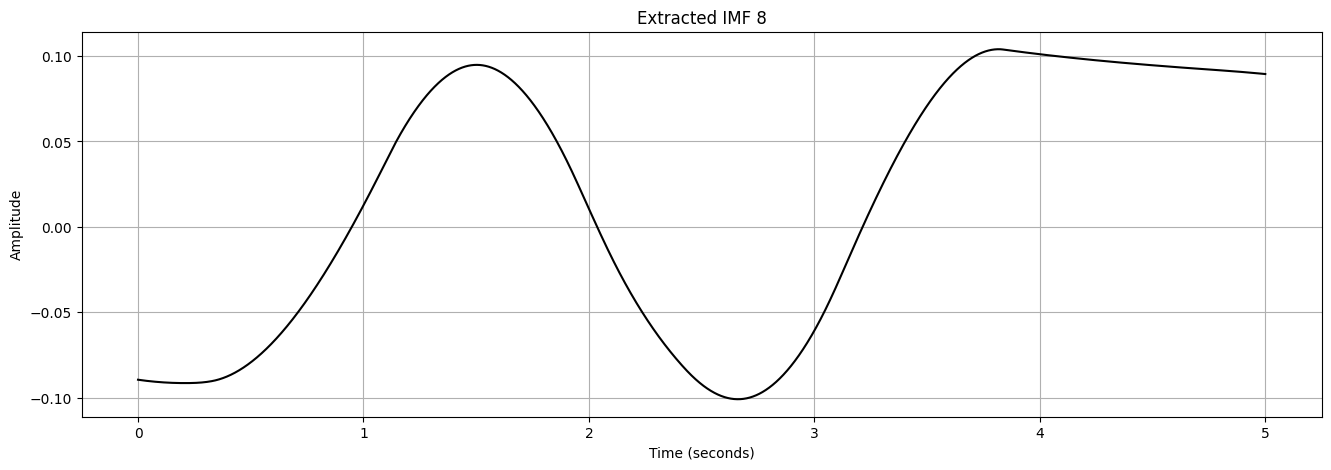

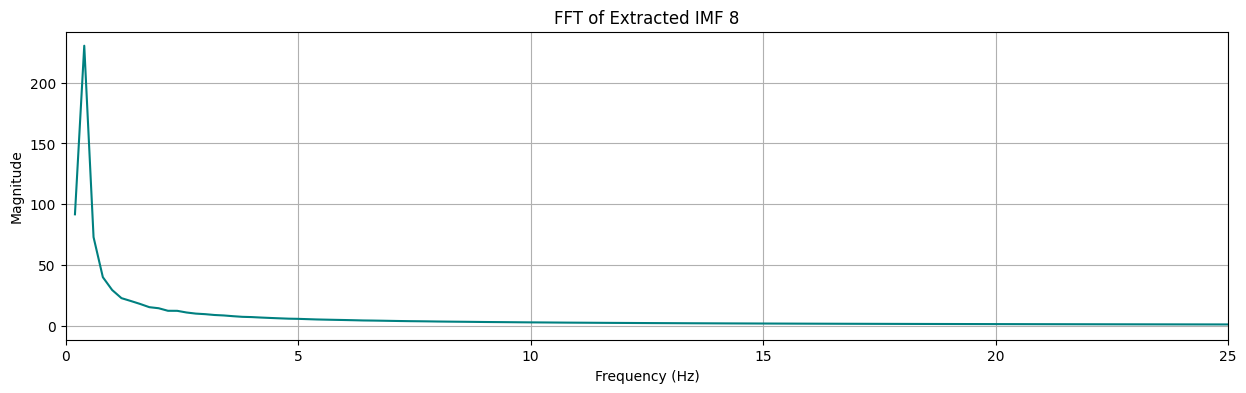

In [10]:
for i in range(len(imfs)):
  plt.figure(figsize=(16,5))
  plt.title(f'Extracted IMF {i+1}')
  plt.plot(t,imfs[i], color='black')
  plt.grid(True)
  plt.xlabel('Time (seconds)')
  plt.ylabel('Amplitude')
  plt.show()


  magn_imf = fft(imfs[i])
  freq_imf = fftfreq(len(imfs[i]), d=1/fs)

  idxs = np.where(freq_imf > 0)
  freq_imf = freq_imf[idxs]
  magn_imf = np.abs(magn_imf[idxs])

  plt.figure(figsize=(15, 4))
  plt.plot(freq_imf, magn_imf, color='teal')
  plt.title(f"FFT of Extracted IMF {i+1}")
  plt.xlim([0, 25])
  plt.xlabel("Frequency (Hz)")
  plt.ylabel("Magnitude")
  plt.grid(True)
  plt.show()

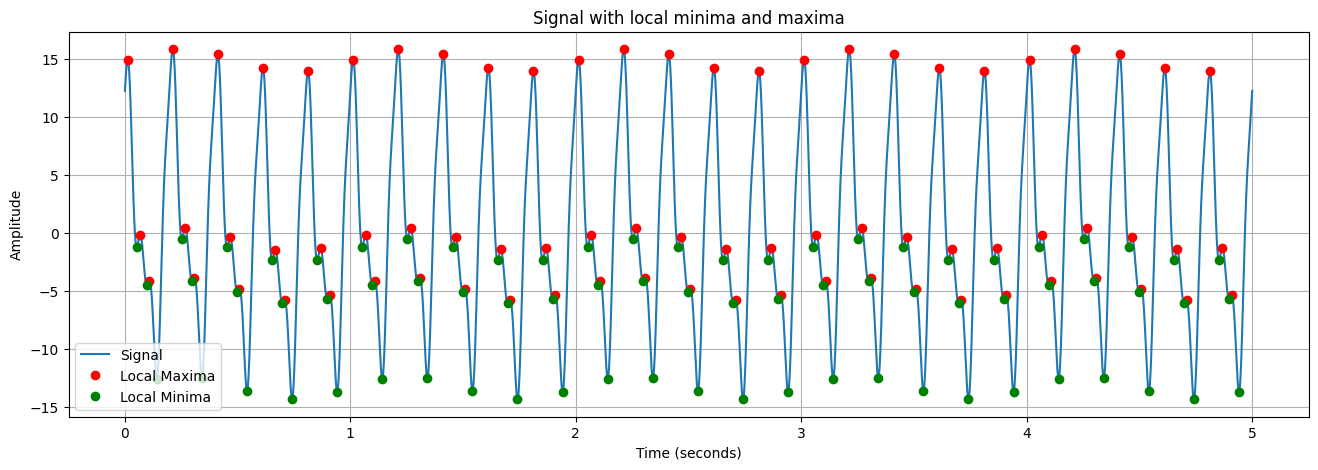

In [ ]:
#for i in range(len(components)):
signal_pos_peaks, signal_pos_peaks_props = find_peaks(signal,
                                                      #prominence=0.5,
                                                      )
signal_neg_peaks, signal_pos_peaks_props = find_peaks(-signal,
                                                      #prominence=0.5,
                                                      )
signal_pos_peak_times = t[signal_pos_peaks]
signal_neg_peak_times = t[signal_neg_peaks]

plt.figure(figsize=(16,5))
plt.title('Signal with local minima and maxima')

plt.plot(t,signal, label = 'Signal')

plt.plot(signal_pos_peak_times, signal[signal_pos_peaks], 'o', color='r',
         label = 'Local Maxima')

plt.plot(signal_neg_peak_times, signal[signal_neg_peaks], 'o', color='g',
         label = 'Local Minima')

plt.grid(True)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

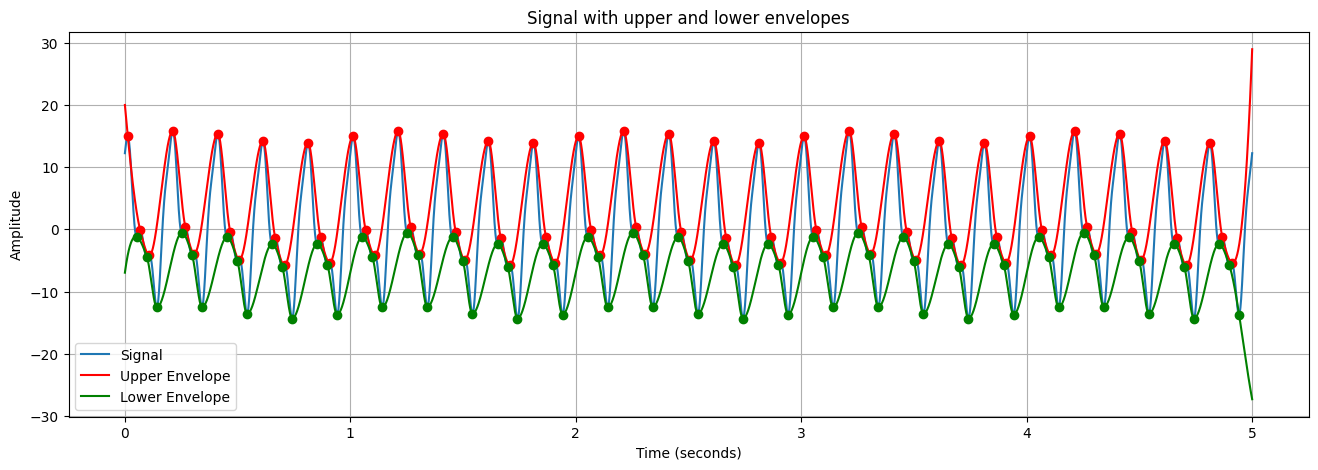

In [ ]:
upper_envelope = PchipInterpolator(signal_pos_peak_times, signal[signal_pos_peaks], extrapolate=True)(t)
lower_envelope = PchipInterpolator(signal_neg_peak_times, signal[signal_neg_peaks], extrapolate=True)(t)


plt.figure(figsize=(16,5))
plt.title('Signal with upper and lower envelopes')

plt.plot(t,signal, label = 'Signal')

plt.plot(signal_pos_peak_times, signal[signal_pos_peaks], 'o', color='r')
plt.plot(t, upper_envelope, color='r', label = 'Upper Envelope')

plt.plot(signal_neg_peak_times, signal[signal_neg_peaks], 'o', color='g')
plt.plot(t, lower_envelope, color='g', label = 'Lower Envelope')

plt.grid(True)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

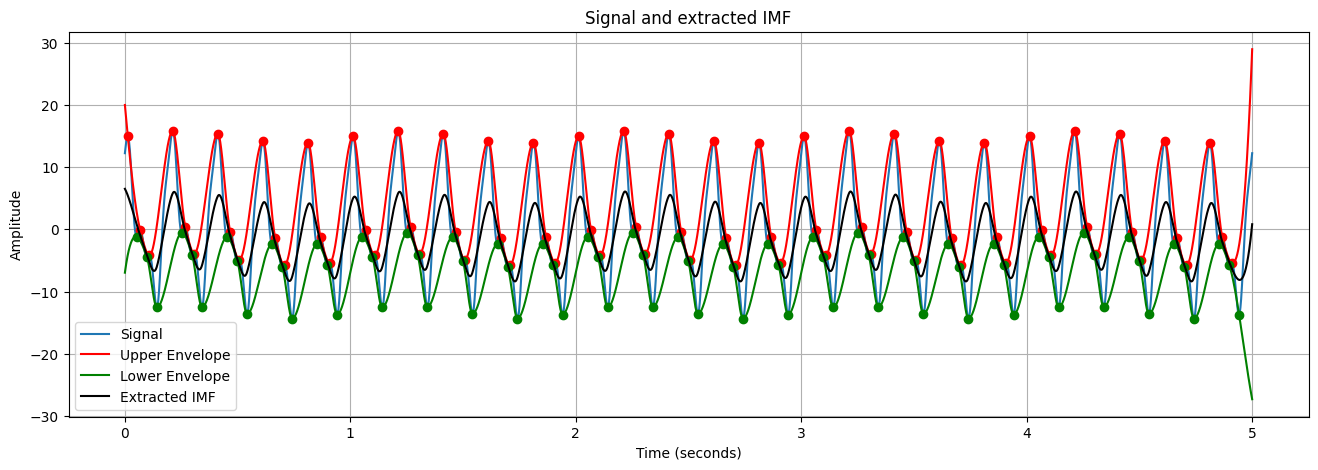

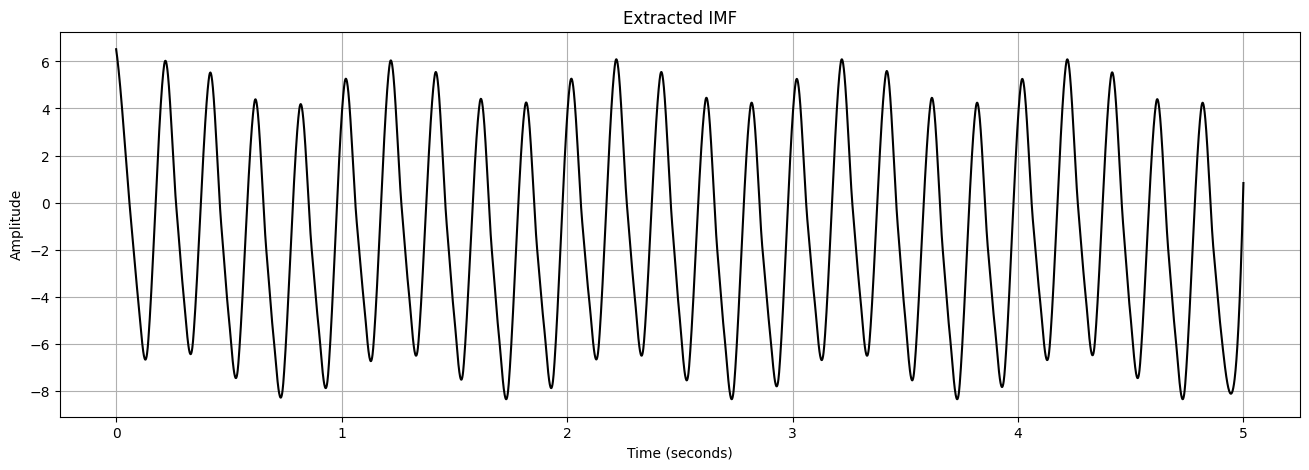

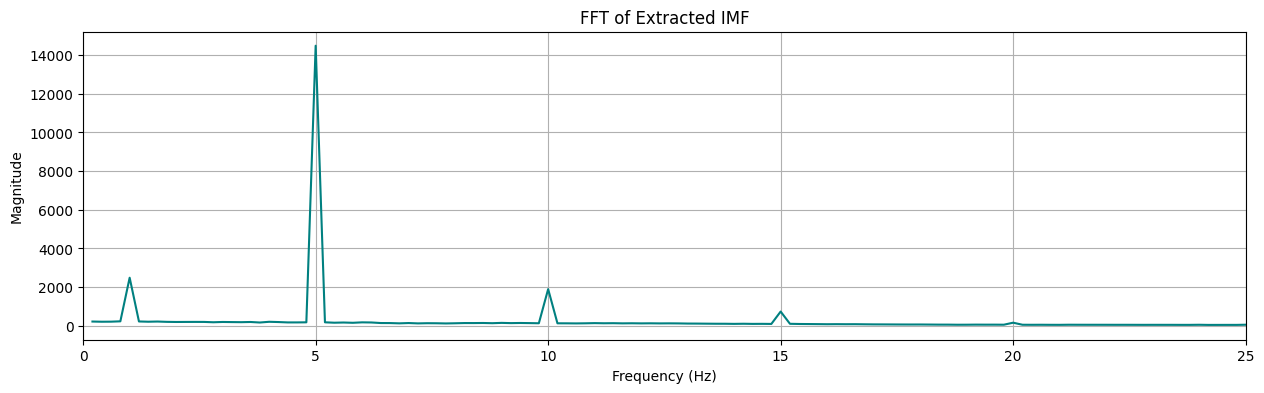

In [ ]:
imf = (upper_envelope + lower_envelope) / 2

plt.figure(figsize=(16,5))
plt.title('Signal and extracted IMF')

plt.plot(t,signal, label = 'Signal')

plt.plot(signal_pos_peak_times, signal[signal_pos_peaks], 'o', color='r')
plt.plot(t, upper_envelope, color='r', label = 'Upper Envelope')

plt.plot(signal_neg_peak_times, signal[signal_neg_peaks], 'o', color='g')
plt.plot(t, lower_envelope, color='g', label = 'Lower Envelope')

plt.plot(t,imf, color='black' ,label = 'Extracted IMF')

plt.grid(True)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


plt.figure(figsize=(16,5))
plt.title('Extracted IMF')
plt.plot(t,imf, color='black')
plt.grid(True)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()


magn_imf = fft(imf)
freq_imf = fftfreq(len(imf), d=1/fs)

idxs = np.where(freq_imf > 0)
freq_test = freq_imf[idxs]
magn_test = np.abs(magn_imf[idxs])

plt.figure(figsize=(15, 4))
plt.plot(freq_test, magn_test, color='teal')
plt.title(f"FFT of Extracted IMF")
plt.xlim([0, 25])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()

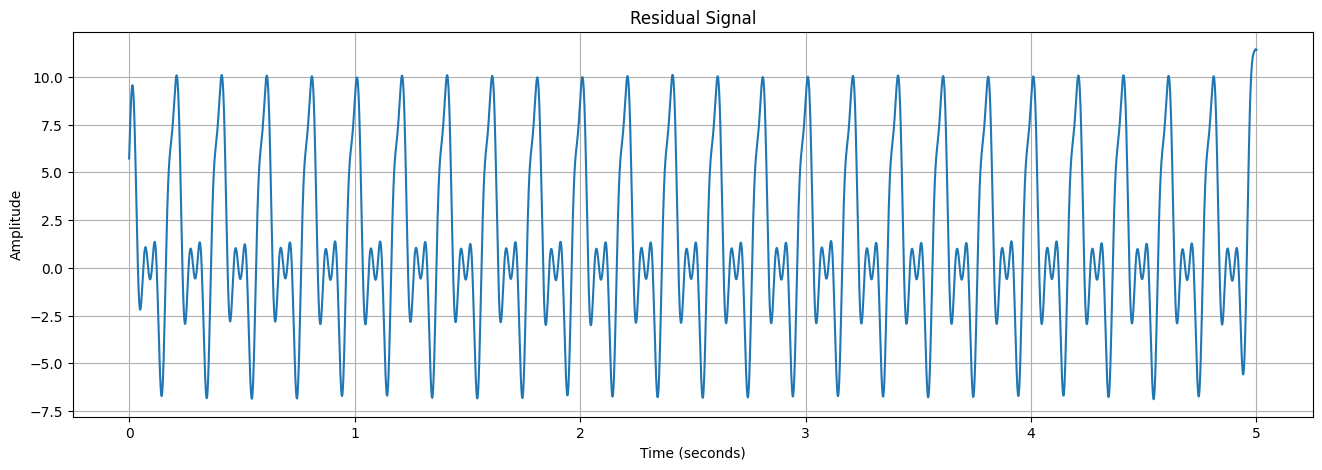

In [ ]:
residual_signal = signal - imf

plt.figure(figsize=(16,5))
plt.title('Residual Signal')
plt.plot(t, residual_signal)
plt.grid(True)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()